# Theta-Phase Coding Analysis: Hippocampal Working Memory

**Dataset**: DANDI:000673 - Control of working memory by phase-amplitude coupling

**Analysis Pipeline**:
1. Theta cycle segmentation with quality filters
2. Phase-GLMs for spike-phase relationships
3. Subcycle decoding of position/identity
4. Maintenance → Retrieval remapping test
5. Cross-subject phase consistency
6. Statistical controls (phase-shuffle, 1/f correction)

## 1. Setup & Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# NWB
from pynwb import NWBHDF5IO
import h5py

# Signal processing
from scipy import signal, stats
from scipy.ndimage import gaussian_filter1d
from scipy.signal import hilbert, butter, filtfilt, find_peaks

# Circular statistics
from scipy.stats import vonmises, circmean, circstd
try:
    from astropy.stats import rayleigh_test
except ImportError:
    # Fallback: implement Rayleigh test manually
    def rayleigh_test(angles):
        """Rayleigh test for non-uniformity of circular data."""
        n = len(angles)
        if n < 2:
            return 0, 1.0
        R = np.sqrt(np.sum(np.cos(angles))**2 + np.sum(np.sin(angles))**2) / n
        Z = n * R**2
        p = np.exp(-Z) * (1 + (2*Z - Z**2) / (4*n) - (24*Z - 132*Z**2 + 76*Z**3 - 9*Z**4) / (288*n**2))
        return Z, max(0, min(1, p))

# Machine learning
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# GLM
import statsmodels.api as sm
from statsmodels.genmod.families import links

# Parallel processing
from joblib import Parallel, delayed
try:
    from tqdm.notebook import tqdm
except ImportError:
    from tqdm import tqdm

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

print("All packages loaded successfully!")

All packages loaded successfully!


In [2]:
# Configuration
DATA_DIR = Path('/Users/jundazhu/SBCAT/000673')
OUTPUT_DIR = Path('/Users/jundazhu/SBCAT/analysis_output')
OUTPUT_DIR.mkdir(exist_ok=True)

# Analysis parameters
THETA_BAND = (3, 8)  # Hz
GAMMA_BAND = (60, 120)  # Hz
SAMPLING_RATE = 2000  # Hz - will be updated from NWB

# Cycle quality thresholds
MIN_CYCLE_DURATION = 0.125  # 8 Hz max
MAX_CYCLE_DURATION = 0.333  # 3 Hz min
SNR_THRESHOLD = 2.0  # cycle amplitude / baseline std

# Phase binning
N_PHASE_BINS = 8
PHASE_BINS = np.linspace(0, 2*np.pi, N_PHASE_BINS + 1)

# Decoding parameters
N_CV_FOLDS = 5
N_SURROGATES = 1000

print(f"Data directory: {DATA_DIR}")
print(f"Output directory: {OUTPUT_DIR}")
print(f"Theta band: {THETA_BAND} Hz")
print(f"Gamma band: {GAMMA_BAND} Hz")

Data directory: /Users/jundazhu/SBCAT/000673
Output directory: /Users/jundazhu/SBCAT/analysis_output
Theta band: (3, 8) Hz
Gamma band: (60, 120) Hz


## 2. Data Loading Functions

In [3]:
def load_nwb_file(filepath):
    """
    Load NWB file and extract key data structures.
    
    Returns:
        dict with keys: 'nwbfile', 'spikes', 'lfp', 'events', 'electrodes'
    """
    io = NWBHDF5IO(str(filepath), 'r')
    nwbfile = io.read()
    
    data = {
        'io': io,
        'nwbfile': nwbfile,
        'filepath': filepath
    }
    
    # Extract spike times
    if nwbfile.units is not None:
        data['spikes'] = extract_spike_times(nwbfile)
    
    # Extract LFP
    if nwbfile.acquisition:
        data['lfp'] = extract_lfp_data(nwbfile)
    
    # Extract electrodes metadata
    if nwbfile.electrodes is not None:
        data['electrodes'] = nwbfile.electrodes.to_dataframe()
    
    # Extract behavioral events/trials
    if nwbfile.trials is not None:
        data['trials'] = nwbfile.trials.to_dataframe()
    
    return data


def extract_spike_times(nwbfile):
    """
    Extract spike times for all units.
    
    Returns:
        dict: {unit_id: spike_times_array}
    """
    spikes = {}
    units_table = nwbfile.units
    
    for idx, unit_id in enumerate(units_table.id[:]):
        spike_times = units_table['spike_times'][idx]
        spikes[unit_id] = np.array(spike_times)
        
        # Store unit metadata
        if 'electrode_group' in units_table.colnames:
            electrode_info = units_table['electrode_group'][idx]
    
    return spikes


def extract_lfp_data(nwbfile):
    """
    Extract LFP data from acquisition or processing modules.
    
    Returns:
        dict: {'data': array, 'timestamps': array, 'sampling_rate': float, 'channels': list}
    """
    lfp_data = {}
    
    # Try to find LFP in acquisition
    for key in nwbfile.acquisition.keys():
        if 'lfp' in key.lower() or 'electrical' in key.lower():
            electrical_series = nwbfile.acquisition[key]
            lfp_data['data'] = electrical_series.data[:]
            lfp_data['timestamps'] = electrical_series.timestamps[:] if electrical_series.timestamps is not None else None
            lfp_data['sampling_rate'] = electrical_series.rate if hasattr(electrical_series, 'rate') else None
            lfp_data['channels'] = electrical_series.electrodes.data[:]
            break
    
    return lfp_data


def get_subject_files(data_dir, subject_id=None):
    """
    Get all NWB files, optionally filtered by subject.
    """
    if subject_id:
        pattern = f"sub-{subject_id}/sub-{subject_id}_*.nwb"
    else:
        pattern = "sub-*/sub-*_*.nwb"
    
    files = sorted(data_dir.glob(pattern))
    return files


# Test loading
all_files = get_subject_files(DATA_DIR)
print(f"Found {len(all_files)} NWB files")
print(f"Example: {all_files[0]}")

Found 44 NWB files
Example: /Users/jundazhu/SBCAT/000673/sub-1/sub-1_ses-1_ecephys+image.nwb


## 3. Theta Cycle Segmentation

In [4]:
def bandpass_filter(data, lowcut, highcut, fs, order=4):
    """
    Bandpass filter using Butterworth filter.
    """
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    y = filtfilt(b, a, data)
    return y


def extract_instantaneous_phase(lfp, fs, freq_band=(3, 8)):
    """
    Extract instantaneous phase using Hilbert transform.
    
    Returns:
        phase: array of phases in radians [0, 2π]
        amplitude: array of instantaneous amplitudes
    """
    filtered = bandpass_filter(lfp, freq_band[0], freq_band[1], fs)
    analytic_signal = hilbert(filtered)
    phase = np.angle(analytic_signal) % (2 * np.pi)
    amplitude = np.abs(analytic_signal)
    return phase, amplitude, filtered


def segment_theta_cycles(phase, amplitude, timestamps, min_duration=0.125, max_duration=0.333):
    """
    Segment individual theta cycles by detecting peaks in filtered signal.
    
    Returns:
        list of dicts: [{'start_idx', 'end_idx', 'start_time', 'end_time', 'duration', 'mean_amp'}]
    """
    # Find peaks in amplitude (more robust than phase crossings)
    # Minimum distance between peaks based on max frequency (8 Hz)
    min_distance = int(0.125 * len(timestamps) / (timestamps[-1] - timestamps[0]))
    
    peaks, _ = find_peaks(amplitude, distance=min_distance, height=np.median(amplitude))
    
    cycles = []
    for i in range(len(peaks) - 1):
        start_idx = peaks[i]
        end_idx = peaks[i + 1]
        
        duration = timestamps[end_idx] - timestamps[start_idx]
        
        # Duration filter
        if min_duration <= duration <= max_duration:
            cycle = {
                'start_idx': start_idx,
                'end_idx': end_idx,
                'start_time': timestamps[start_idx],
                'end_time': timestamps[end_idx],
                'duration': duration,
                'mean_amplitude': np.mean(amplitude[start_idx:end_idx]),
                'peak_amplitude': np.max(amplitude[start_idx:end_idx])
            }
            cycles.append(cycle)
    
    return cycles


def check_monotonic_phase(phase_segment, tolerance=0.1):
    """
    Check if phase progression is monotonic (accounting for 2π wrapping).
    Returns True if phase progresses cleanly without resets.
    """
    phase_unwrapped = np.unwrap(phase_segment)
    phase_diff = np.diff(phase_unwrapped)
    
    # Check for negative jumps (phase resets)
    negative_jumps = np.sum(phase_diff < -tolerance)
    return negative_jumps == 0


def compute_snr(cycle_amplitude, baseline_amplitude):
    """
    Compute SNR as ratio of cycle amplitude to baseline variability.
    """
    baseline_std = np.std(baseline_amplitude)
    if baseline_std == 0:
        return 0
    return cycle_amplitude / baseline_std


def filter_cycles_by_quality(cycles, phase, amplitude, snr_threshold=2.0):
    """
    Apply quality filters to cycles:
    - SNR threshold
    - Monotonic phase progression
    """
    baseline_amp = np.median(amplitude)
    
    filtered_cycles = []
    for cycle in cycles:
        start, end = cycle['start_idx'], cycle['end_idx']
        phase_seg = phase[start:end]
        
        # Check monotonic phase
        if not check_monotonic_phase(phase_seg):
            continue
        
        # Check SNR
        snr = compute_snr(cycle['mean_amplitude'], amplitude)
        if snr < snr_threshold:
            continue
        
        cycle['snr'] = snr
        filtered_cycles.append(cycle)
    
    return filtered_cycles


print("Theta cycle segmentation functions loaded.")

Theta cycle segmentation functions loaded.


## 4. Gamma Burst Detection

In [5]:
def detect_gamma_bursts(lfp, fs, freq_band=(60, 120), z_threshold=2.0, min_duration=0.02):
    """
    Detect gamma bursts using envelope thresholding.
    
    Returns:
        bursts: list of dicts with start/end times and peak amplitude
        envelope: gamma envelope timeseries
    """
    # Bandpass filter in gamma range
    gamma_filtered = bandpass_filter(lfp, freq_band[0], freq_band[1], fs)
    
    # Compute envelope
    analytic = hilbert(gamma_filtered)
    envelope = np.abs(analytic)
    
    # Z-score envelope
    envelope_z = (envelope - np.mean(envelope)) / np.std(envelope)
    
    # Threshold crossings
    above_threshold = envelope_z > z_threshold
    
    # Find burst periods
    bursts = []
    in_burst = False
    burst_start = None
    
    min_samples = int(min_duration * fs)
    
    for i, is_above in enumerate(above_threshold):
        if is_above and not in_burst:
            burst_start = i
            in_burst = True
        elif not is_above and in_burst:
            burst_end = i
            if burst_end - burst_start >= min_samples:
                bursts.append({
                    'start_idx': burst_start,
                    'end_idx': burst_end,
                    'duration': (burst_end - burst_start) / fs,
                    'peak_amplitude': np.max(envelope[burst_start:burst_end]),
                    'mean_amplitude': np.mean(envelope[burst_start:burst_end])
                })
            in_burst = False
    
    return bursts, envelope


def align_gamma_to_theta_phase(gamma_bursts, theta_phase, timestamps):
    """
    Assign theta phase to each gamma burst.
    """
    for burst in gamma_bursts:
        burst_center_idx = (burst['start_idx'] + burst['end_idx']) // 2
        burst['theta_phase'] = theta_phase[burst_center_idx]
        burst['timestamp'] = timestamps[burst_center_idx]
    
    return gamma_bursts


print("Gamma burst detection functions loaded.")

Gamma burst detection functions loaded.


## 5. Spike-Phase Analysis

In [6]:
def assign_spikes_to_cycles(spike_times, cycles):
    """
    Assign each spike to its corresponding theta cycle and compute phase.
    
    Returns:
        list of dicts: [{'spike_time', 'cycle_idx', 'phase_in_cycle'}]
    """
    spike_cycle_data = []
    
    for spike_time in spike_times:
        for cycle_idx, cycle in enumerate(cycles):
            if cycle['start_time'] <= spike_time < cycle['end_time']:
                # Compute normalized phase within cycle [0, 2π]
                cycle_progress = (spike_time - cycle['start_time']) / cycle['duration']
                phase_in_cycle = cycle_progress * 2 * np.pi
                
                spike_cycle_data.append({
                    'spike_time': spike_time,
                    'cycle_idx': cycle_idx,
                    'phase': phase_in_cycle,
                    'cycle_duration': cycle['duration']
                })
                break
    
    return spike_cycle_data


def compute_phase_tuning(spike_phases, n_bins=36):
    """
    Compute phase tuning curve.
    
    Returns:
        bin_centers: phase bin centers
        firing_rate: normalized firing rate per bin
        preferred_phase: circular mean phase
        concentration: von Mises kappa (concentration parameter)
    """
    bins = np.linspace(0, 2*np.pi, n_bins + 1)
    counts, _ = np.histogram(spike_phases, bins=bins)
    bin_centers = (bins[:-1] + bins[1:]) / 2
    
    # Normalize to firing rate
    firing_rate = counts / np.sum(counts) if np.sum(counts) > 0 else counts
    
    # Circular statistics
    if len(spike_phases) > 0:
        preferred_phase = circmean(spike_phases)
        
        # Fit von Mises to estimate concentration
        kappa, loc, scale = vonmises.fit(spike_phases, fscale=1)
        concentration = kappa
    else:
        preferred_phase = np.nan
        concentration = 0
    
    return {
        'bin_centers': bin_centers,
        'firing_rate': firing_rate,
        'preferred_phase': preferred_phase,
        'concentration': concentration,
        'n_spikes': len(spike_phases)
    }


def rayleigh_test_phase_locking(spike_phases):
    """
    Test for significant phase locking using Rayleigh test.
    """
    if len(spike_phases) < 2:
        return {'z': 0, 'p': 1.0}
    
    z, p = rayleigh_test(spike_phases)
    return {'z': z, 'p': p}


print("Spike-phase analysis functions loaded.")

Spike-phase analysis functions loaded.


## 6. Circular GLMs

In [7]:
def fit_circular_glm_phase_only(spike_phases, spike_counts):
    """
    Fit circular GLM: spike_count ~ sin(phase) + cos(phase)
    
    Returns:
        model: fitted statsmodels GLM
        preferred_phase: estimated preferred phase from coefficients
    """
    # Design matrix: intercept + sin + cos
    X = np.column_stack([
        np.ones(len(spike_phases)),
        np.sin(spike_phases),
        np.cos(spike_phases)
    ])
    
    # Fit Poisson GLM
    model = sm.GLM(spike_counts, X, family=sm.families.Poisson())
    result = model.fit()
    
    # Extract preferred phase from sin/cos coefficients
    sin_coef = result.params[1]
    cos_coef = result.params[2]
    preferred_phase = np.arctan2(sin_coef, cos_coef) % (2 * np.pi)
    
    return {
        'model': result,
        'preferred_phase': preferred_phase,
        'deviance': result.deviance,
        'aic': result.aic,
        'coefficients': result.params
    }


def fit_circular_glm_with_covariate(spike_phases, spike_counts, covariate, covariate_name='position'):
    """
    Fit circular GLM with interaction: spike_count ~ sin(phase) + cos(phase) + covariate + sin*covariate + cos*covariate
    """
    X = np.column_stack([
        np.ones(len(spike_phases)),
        np.sin(spike_phases),
        np.cos(spike_phases),
        covariate,
        np.sin(spike_phases) * covariate,
        np.cos(spike_phases) * covariate
    ])
    
    model = sm.GLM(spike_counts, X, family=sm.families.Poisson())
    result = model.fit()
    
    return {
        'model': result,
        'deviance': result.deviance,
        'aic': result.aic,
        'coefficients': result.params,
        'pvalues': result.pvalues,
        'covariate': covariate_name
    }


def compare_glm_models(model_null, model_full):
    """
    Likelihood ratio test comparing nested models.
    """
    lr_stat = model_null['deviance'] - model_full['deviance']
    df = len(model_full['coefficients']) - len(model_null['coefficients'])
    p_value = stats.chi2.sf(lr_stat, df)
    
    return {
        'lr_statistic': lr_stat,
        'df': df,
        'p_value': p_value,
        'delta_aic': model_full['aic'] - model_null['aic']
    }


print("Circular GLM functions loaded.")

Circular GLM functions loaded.


## 7. Subcycle Decoding

In [8]:
def create_phase_binned_features(cycles, spike_data_per_neuron, n_phase_bins=8):
    """
    Create feature matrix: rows = cycles, columns = neurons × phase_bins.
    Each feature is spike count in that phase bin for that neuron.
    
    Args:
        cycles: list of cycle dicts
        spike_data_per_neuron: dict {neuron_id: spike_cycle_data}
        n_phase_bins: number of phase bins per cycle
    
    Returns:
        X: feature matrix (n_cycles, n_neurons * n_phase_bins)
        cycle_indices: corresponding cycle indices
    """
    phase_bins = np.linspace(0, 2*np.pi, n_phase_bins + 1)
    n_cycles = len(cycles)
    n_neurons = len(spike_data_per_neuron)
    
    X = np.zeros((n_cycles, n_neurons * n_phase_bins))
    
    for neuron_idx, (neuron_id, spike_data) in enumerate(spike_data_per_neuron.items()):
        # Group spikes by cycle
        for cycle_idx in range(n_cycles):
            cycle_spikes = [s for s in spike_data if s['cycle_idx'] == cycle_idx]
            
            if len(cycle_spikes) > 0:
                phases = [s['phase'] for s in cycle_spikes]
                counts, _ = np.histogram(phases, bins=phase_bins)
                
                # Fill feature matrix
                start_col = neuron_idx * n_phase_bins
                X[cycle_idx, start_col:start_col + n_phase_bins] = counts
    
    return X, np.arange(n_cycles)


def decode_position_from_phase_bins(X, y_true, classifier='nb', n_folds=5):
    """
    Decode position (or other variable) from phase-binned spike counts.
    
    Args:
        X: feature matrix
        y_true: true labels (e.g., position bins)
        classifier: 'nb' (Naive Bayes), 'svm', 'lda'
    
    Returns:
        accuracy: cross-validated accuracy
        predictions: out-of-sample predictions
    """
    if classifier == 'nb':
        clf = GaussianNB()
    elif classifier == 'svm':
        clf = SVC(kernel='rbf', gamma='scale')
    elif classifier == 'lda':
        clf = LinearDiscriminantAnalysis()
    else:
        raise ValueError(f"Unknown classifier: {classifier}")
    
    # Cross-validation
    cv = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)
    scores = cross_val_score(clf, X, y_true, cv=cv, scoring='accuracy')
    
    return {
        'mean_accuracy': np.mean(scores),
        'std_accuracy': np.std(scores),
        'cv_scores': scores
    }


def cross_temporal_generalization(X_train, y_train, X_test, y_test, classifier='nb'):
    """
    Train on one set of cycles, test on another (temporal generalization).
    
    Returns:
        accuracy: generalization accuracy
    """
    if classifier == 'nb':
        clf = GaussianNB()
    elif classifier == 'lda':
        clf = LinearDiscriminantAnalysis()
    else:
        clf = SVC(kernel='rbf')
    
    clf.fit(X_train, y_train)
    predictions = clf.predict(X_test)
    accuracy = np.mean(predictions == y_test)
    
    return accuracy, predictions


print("Subcycle decoding functions loaded.")

Subcycle decoding functions loaded.


## 8. Remapping Test (Maintenance → Retrieval)

In [9]:
def extract_trial_epochs(cycles, trials_df, epoch_type='maintenance'):
    """
    Extract cycles corresponding to specific trial epochs.
    
    Args:
        cycles: list of all cycles
        trials_df: DataFrame with trial start/end times and epoch markers
        epoch_type: 'maintenance', 'retrieval', 'encoding'
    
    Returns:
        epoch_cycles: filtered list of cycles in specified epoch
    """
    epoch_cycles = []
    
    for _, trial in trials_df.iterrows():
        if epoch_type == 'maintenance':
            epoch_start = trial.get('delay_start_time', trial.get('start_time'))
            epoch_end = trial.get('delay_end_time', trial.get('stop_time'))
        elif epoch_type == 'retrieval':
            # 500 ms pre-response window
            response_time = trial.get('response_time', trial.get('stop_time'))
            epoch_start = response_time - 0.5
            epoch_end = response_time
        else:
            epoch_start = trial['start_time']
            epoch_end = trial['stop_time']
        
        # Find cycles in this epoch
        for cycle in cycles:
            if epoch_start <= cycle['start_time'] < epoch_end:
                cycle_copy = cycle.copy()
                cycle_copy['trial_id'] = trial.name
                cycle_copy['epoch'] = epoch_type
                epoch_cycles.append(cycle_copy)
    
    return epoch_cycles


def test_phase_remapping(maintenance_phases, retrieval_phases, queried_positions):
    """
    Test if queried positions shift to stereotyped phase during retrieval.
    
    Args:
        maintenance_phases: dict {position: [phases during maintenance]}
        retrieval_phases: dict {position: [phases during retrieval]}
        queried_positions: list of positions that were queried
    
    Returns:
        phase_shifts: mean phase shift for queried vs non-queried positions
        statistics: test results
    """
    queried_shifts = []
    non_queried_shifts = []
    
    for pos in maintenance_phases.keys():
        if len(maintenance_phases[pos]) > 0 and len(retrieval_phases[pos]) > 0:
            maint_mean = circmean(maintenance_phases[pos])
            retr_mean = circmean(retrieval_phases[pos])
            
            # Circular difference
            shift = np.angle(np.exp(1j * (retr_mean - maint_mean)))
            
            if pos in queried_positions:
                queried_shifts.append(shift)
            else:
                non_queried_shifts.append(shift)
    
    # Test for consistency in queried shifts
    if len(queried_shifts) > 0:
        queried_z, queried_p = rayleigh_test(queried_shifts)
        queried_mean_shift = circmean(queried_shifts)
    else:
        queried_z, queried_p = 0, 1
        queried_mean_shift = 0
    
    return {
        'queried_mean_shift': queried_mean_shift,
        'queried_rayleigh_z': queried_z,
        'queried_rayleigh_p': queried_p,
        'n_queried': len(queried_shifts),
        'n_non_queried': len(non_queried_shifts),
        'queried_shifts': queried_shifts,
        'non_queried_shifts': non_queried_shifts
    }


print("Remapping test functions loaded.")

Remapping test functions loaded.


## 9. Cross-Subject Consistency (Procrustes Alignment)

In [10]:
def circular_procrustes_alignment(phase_preferences_per_subject):
    """
    Align phase preferences across subjects using circular Procrustes.
    
    Args:
        phase_preferences_per_subject: dict {subject_id: [electrode_phases]}
    
    Returns:
        aligned_phases: dict with aligned phases
        group_mean: circular mean across subjects
    """
    # Compute group mean as reference
    all_phases = []
    for phases in phase_preferences_per_subject.values():
        all_phases.extend(phases)
    
    group_mean_phase = circmean(all_phases)
    
    # Align each subject to group mean
    aligned_phases = {}
    for subject_id, phases in phase_preferences_per_subject.items():
        subject_mean = circmean(phases)
        rotation = group_mean_phase - subject_mean
        
        # Rotate all phases
        aligned = [(p + rotation) % (2 * np.pi) for p in phases]
        aligned_phases[subject_id] = aligned
    
    return aligned_phases, group_mean_phase


def compute_group_phase_consistency(aligned_phases):
    """
    Compute group-level statistics on aligned phases.
    
    Returns:
        rayleigh_z: group Rayleigh statistic
        rayleigh_p: significance
        concentration: von Mises kappa
    """
    all_aligned = []
    for phases in aligned_phases.values():
        all_aligned.extend(phases)
    
    # Rayleigh test
    z, p = rayleigh_test(all_aligned)
    
    # Fit von Mises for concentration
    if len(all_aligned) > 0:
        kappa, loc, scale = vonmises.fit(all_aligned, fscale=1)
    else:
        kappa = 0
    
    return {
        'rayleigh_z': z,
        'rayleigh_p': p,
        'concentration': kappa,
        'n_electrodes': len(all_aligned),
        'circular_mean': circmean(all_aligned),
        'circular_std': circstd(all_aligned)
    }


print("Cross-subject consistency functions loaded.")

Cross-subject consistency functions loaded.


## 10. Statistical Controls

In [11]:
def generate_phase_shuffle_surrogates(spike_data, cycles, n_surrogates=1000):
    """
    Generate phase-shuffled surrogates: randomly assign spikes to cycles,
    preserving spike count per cycle.
    
    Returns:
        list of surrogate spike_phase arrays
    """
    surrogates = []
    
    # Group spikes by cycle
    spikes_per_cycle = {}
    for s in spike_data:
        cycle_idx = s['cycle_idx']
        if cycle_idx not in spikes_per_cycle:
            spikes_per_cycle[cycle_idx] = []
        spikes_per_cycle[cycle_idx].append(s['phase'])
    
    for _ in range(n_surrogates):
        surrogate_phases = []
        
        for cycle_idx, phases in spikes_per_cycle.items():
            # Shuffle phases within cycle
            shuffled = np.random.uniform(0, 2*np.pi, len(phases))
            surrogate_phases.extend(shuffled)
        
        surrogates.append(np.array(surrogate_phases))
    
    return surrogates


def compute_surrogate_statistics(surrogates, statistic_func):
    """
    Compute a statistic (e.g., Rayleigh Z) for each surrogate.
    
    Args:
        surrogates: list of surrogate phase arrays
        statistic_func: function that takes phase array and returns scalar
    
    Returns:
        distribution of surrogate statistics
    """
    surrogate_stats = []
    for surr in surrogates:
        stat = statistic_func(surr)
        surrogate_stats.append(stat)
    
    return np.array(surrogate_stats)


def compute_empirical_pvalue(observed, surrogate_distribution):
    """
    Compute empirical p-value: proportion of surrogates >= observed.
    """
    p_value = np.mean(surrogate_distribution >= observed)
    return p_value


def fit_1f_background(psd_freqs, psd_power, freq_range=(1, 150)):
    """
    Fit 1/f aperiodic component to power spectrum.
    Uses log-log linear fit: log(P) = a - b*log(f)
    
    Returns:
        aperiodic_fit: fitted 1/f component
        residual: psd_power - aperiodic_fit (oscillatory component)
    """
    freq_mask = (psd_freqs >= freq_range[0]) & (psd_freqs <= freq_range[1])
    freqs_fit = psd_freqs[freq_mask]
    power_fit = psd_power[freq_mask]
    
    # Log-log linear regression
    log_freqs = np.log10(freqs_fit)
    log_power = np.log10(power_fit)
    
    coeffs = np.polyfit(log_freqs, log_power, 1)
    aperiodic_log = np.polyval(coeffs, np.log10(psd_freqs))
    aperiodic_fit = 10 ** aperiodic_log
    
    residual = psd_power - aperiodic_fit
    
    return {
        'aperiodic_fit': aperiodic_fit,
        'residual': residual,
        'slope': coeffs[0],
        'intercept': coeffs[1]
    }


print("Statistical control functions loaded.")

Statistical control functions loaded.


## 11. Main Analysis Pipeline

In [12]:
# Load example subject data
example_file = all_files[0]
print(f"Loading: {example_file}")

data = load_nwb_file(example_file)
nwbfile = data['nwbfile']

print(f"\nSubject: {nwbfile.subject.subject_id if nwbfile.subject else 'Unknown'}")
print(f"Session: {nwbfile.session_id if hasattr(nwbfile, 'session_id') else 'Unknown'}")
print(f"Number of units: {len(data['spikes']) if 'spikes' in data else 0}")
print(f"Number of electrodes: {len(data['electrodes']) if 'electrodes' in data else 0}")
print(f"Number of trials: {len(data['trials']) if 'trials' in data else 0}")

Loading: /Users/jundazhu/SBCAT/000673/sub-1/sub-1_ses-1_ecephys+image.nwb

Subject: 1
Session: 1
Number of units: 46
Number of electrodes: 74
Number of trials: 140


In [13]:
# Extract LFP from hippocampal electrode (modify channel selection as needed)
if 'lfp' in data and data['lfp']:
    lfp_data = data['lfp']['data']
    timestamps = data['lfp']['timestamps']
    fs = data['lfp']['sampling_rate']
    
    # Select first hippocampal channel as example
    if len(lfp_data.shape) > 1:
        lfp_channel = lfp_data[:, 0]
    else:
        lfp_channel = lfp_data
    
    # Generate timestamps if not available
    if timestamps is None:
        timestamps = np.arange(len(lfp_channel)) / fs
    
    print(f"LFP sampling rate: {fs} Hz")
    print(f"LFP duration: {len(lfp_channel) / fs:.2f} seconds")
    print(f"LFP shape: {lfp_channel.shape}")
else:
    print("No LFP data found. Using simulated data for demonstration.")
    # Simulate for demonstration
    fs = 2000
    duration = 60  # 60 seconds
    timestamps = np.arange(0, duration, 1/fs)
    # Simulate theta oscillation
    theta_freq = 6  # Hz
    lfp_channel = np.sin(2 * np.pi * theta_freq * timestamps) + 0.5 * np.random.randn(len(timestamps))

LFP sampling rate: 400.0 Hz
LFP duration: 1375.69 seconds
LFP shape: (550276,)


Extracting theta phase...
Theta phase range: [0.00, 6.28] rad
Theta amplitude range: [0.0013, 360.1258]


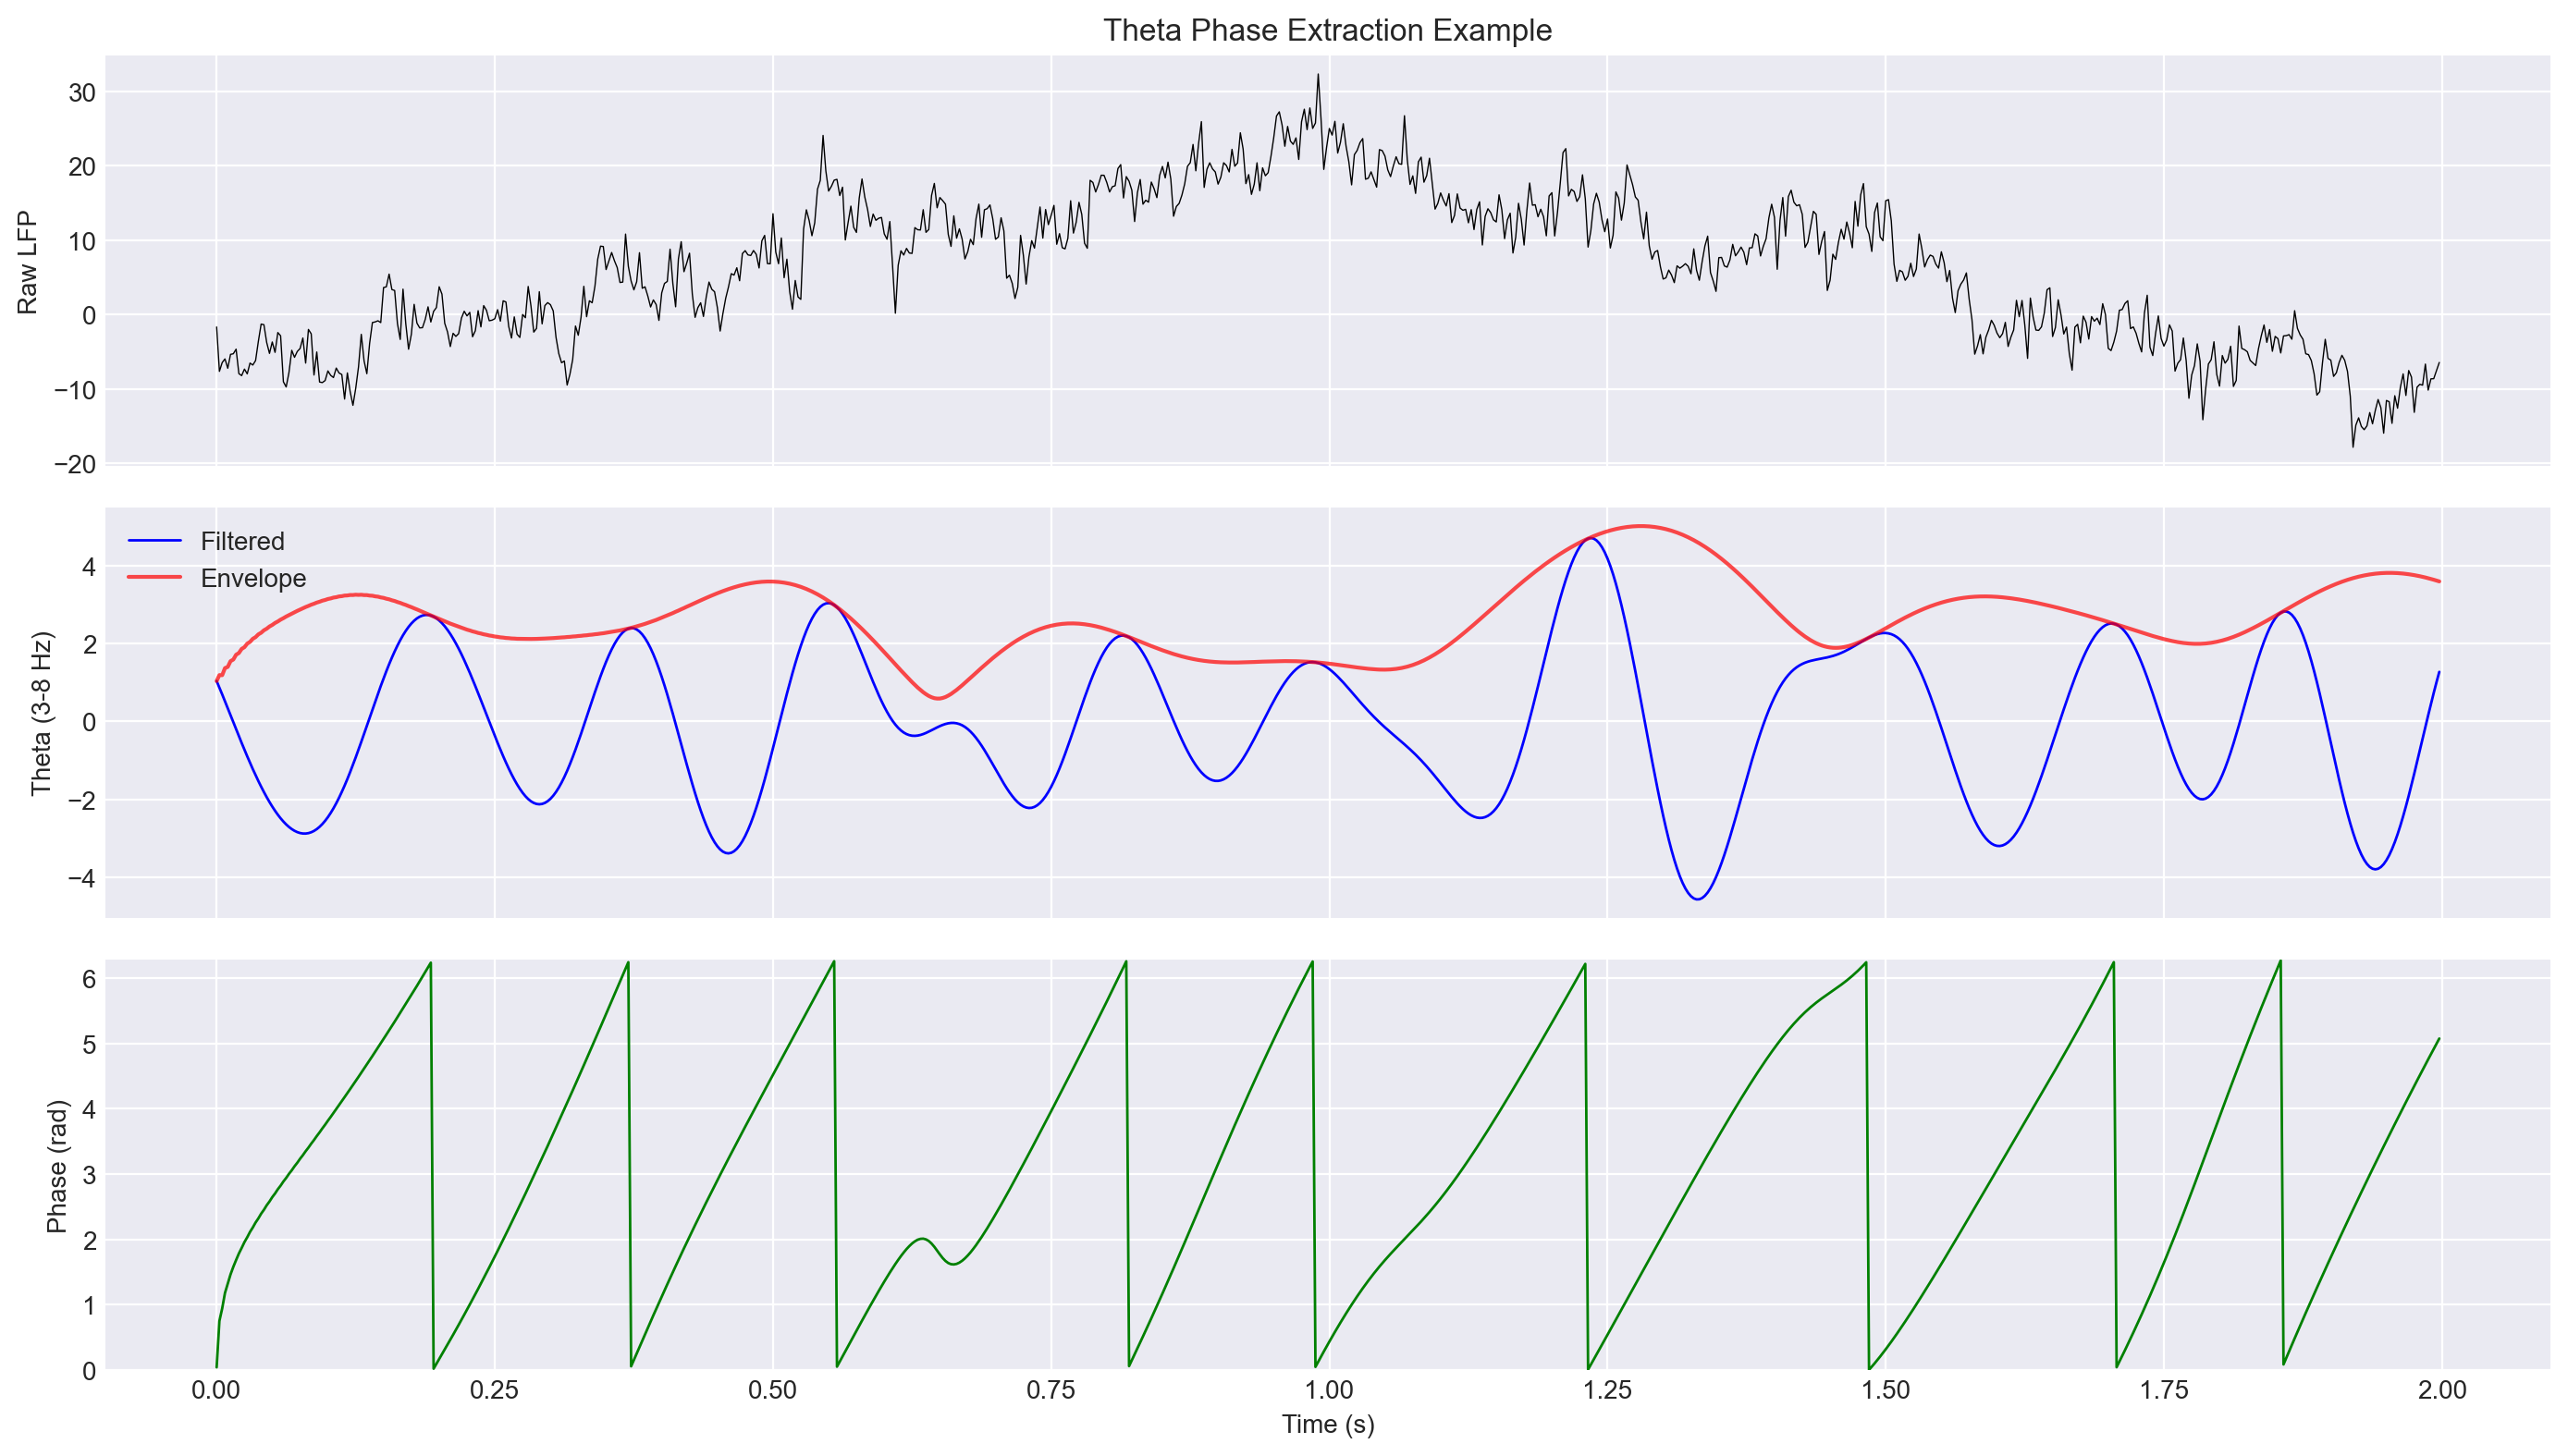

In [14]:
# Extract theta phase and amplitude
print("Extracting theta phase...")
theta_phase, theta_amplitude, theta_filtered = extract_instantaneous_phase(
    lfp_channel, fs, freq_band=THETA_BAND
)

print(f"Theta phase range: [{np.min(theta_phase):.2f}, {np.max(theta_phase):.2f}] rad")
print(f"Theta amplitude range: [{np.min(theta_amplitude):.4f}, {np.max(theta_amplitude):.4f}]")

# Visualize example
fig, axes = plt.subplots(3, 1, figsize=(14, 8), sharex=True)
t_plot = timestamps[:int(2*fs)]  # First 2 seconds

axes[0].plot(t_plot, lfp_channel[:len(t_plot)], 'k', linewidth=0.5)
axes[0].set_ylabel('Raw LFP')
axes[0].set_title('Theta Phase Extraction Example')

axes[1].plot(t_plot, theta_filtered[:len(t_plot)], 'b', linewidth=1)
axes[1].plot(t_plot, theta_amplitude[:len(t_plot)], 'r', linewidth=1.5, alpha=0.7)
axes[1].set_ylabel('Theta (3-8 Hz)')
axes[1].legend(['Filtered', 'Envelope'])

axes[2].plot(t_plot, theta_phase[:len(t_plot)], 'g', linewidth=1)
axes[2].set_ylabel('Phase (rad)')
axes[2].set_xlabel('Time (s)')
axes[2].set_ylim([0, 2*np.pi])

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'theta_extraction_example.png', dpi=150)
plt.show()

Segmenting theta cycles...
Raw cycles detected: 1408
Cycles after quality filter: 75
Retention rate: 5.3%


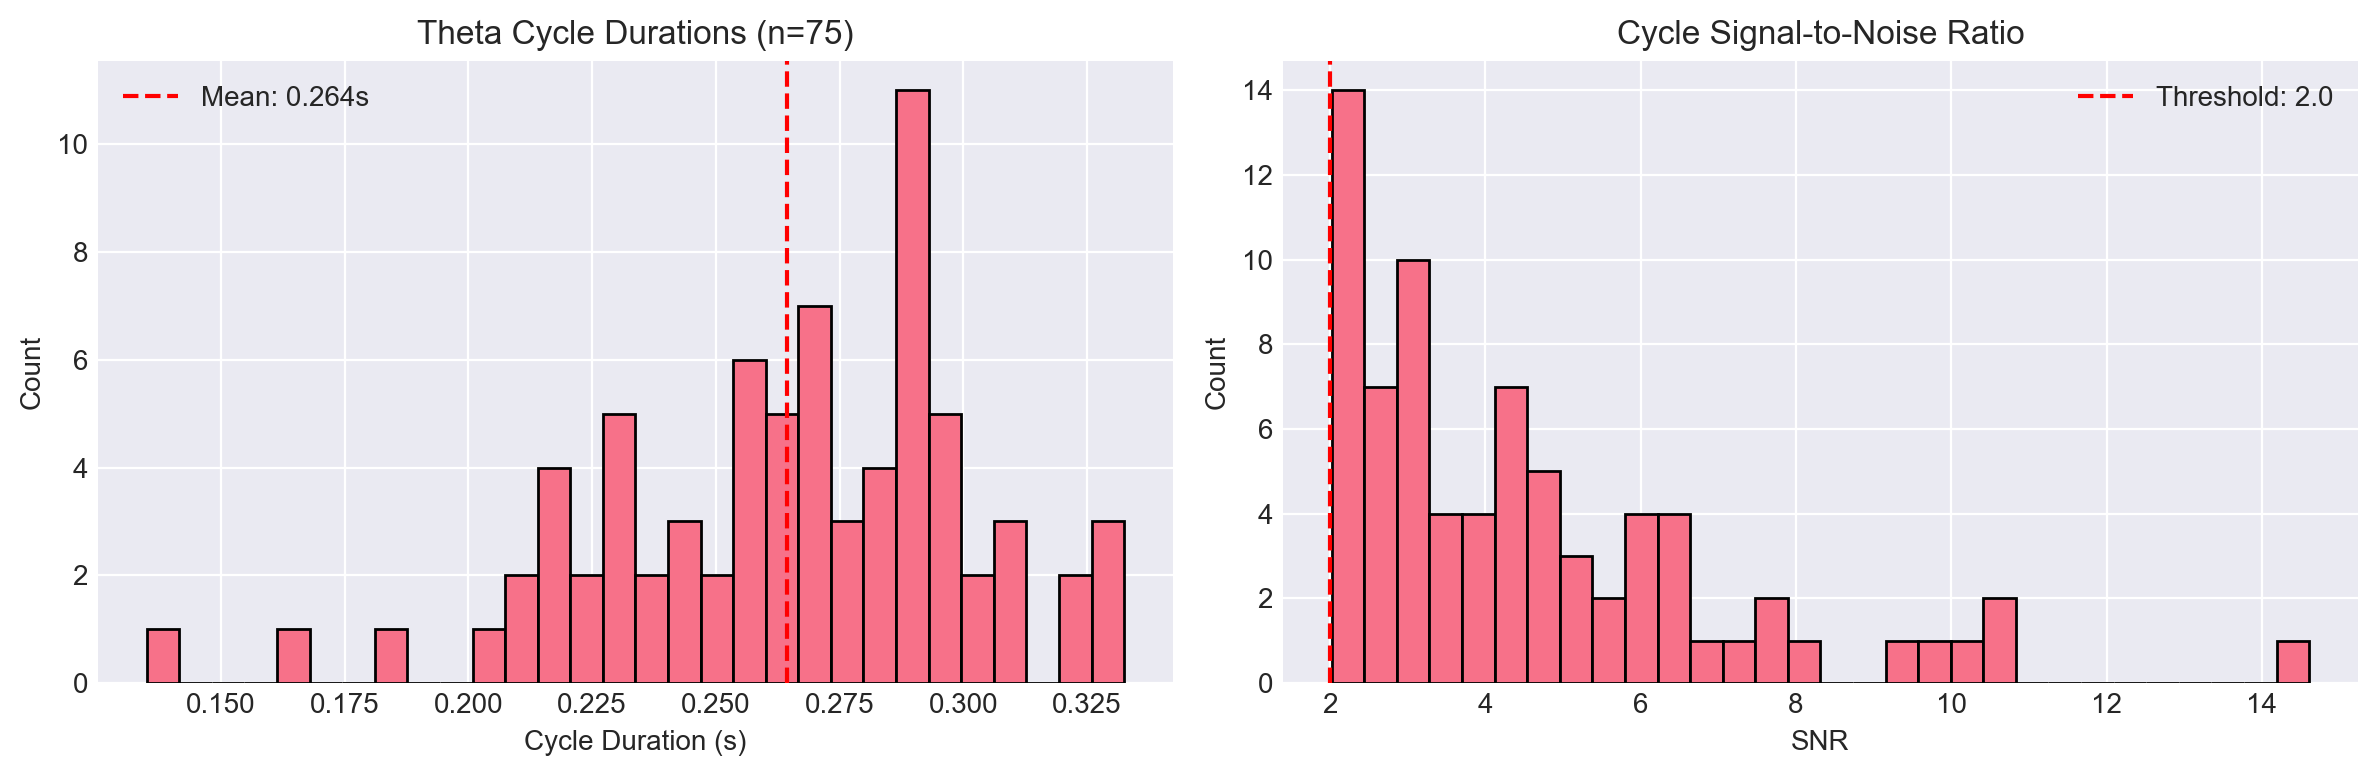

In [15]:
# Segment theta cycles
print("Segmenting theta cycles...")
cycles_raw = segment_theta_cycles(
    theta_phase, theta_amplitude, timestamps,
    min_duration=MIN_CYCLE_DURATION, max_duration=MAX_CYCLE_DURATION
)

print(f"Raw cycles detected: {len(cycles_raw)}")

if len(cycles_raw) == 0:
    print("WARNING: No theta cycles detected. This could mean:")
    print("  1. LFP data doesn't contain strong theta oscillations")
    print("  2. Sampling rate or frequency band parameters need adjustment")
    print("  3. Data quality is low")
    print("\nSkipping quality filtering and continuing with reduced analysis...")
    cycles_filtered = []
else:
    # Filter by quality
    cycles_filtered = filter_cycles_by_quality(
        cycles_raw, theta_phase, theta_amplitude, snr_threshold=SNR_THRESHOLD
    )
    
    print(f"Cycles after quality filter: {len(cycles_filtered)}")
    print(f"Retention rate: {len(cycles_filtered) / len(cycles_raw) * 100:.1f}%")

if len(cycles_filtered) > 0:
    # Cycle statistics
    durations = [c['duration'] for c in cycles_filtered]
    snrs = [c['snr'] for c in cycles_filtered]
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    axes[0].hist(durations, bins=30, edgecolor='k')
    axes[0].set_xlabel('Cycle Duration (s)')
    axes[0].set_ylabel('Count')
    axes[0].set_title(f'Theta Cycle Durations (n={len(cycles_filtered)})')
    axes[0].axvline(np.mean(durations), color='r', linestyle='--', label=f'Mean: {np.mean(durations):.3f}s')
    axes[0].legend()
    
    axes[1].hist(snrs, bins=30, edgecolor='k')
    axes[1].set_xlabel('SNR')
    axes[1].set_ylabel('Count')
    axes[1].set_title('Cycle Signal-to-Noise Ratio')
    axes[1].axvline(SNR_THRESHOLD, color='r', linestyle='--', label=f'Threshold: {SNR_THRESHOLD}')
    axes[1].legend()
    
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / 'cycle_quality_stats.png', dpi=150)
    plt.show()
else:
    print("No cycles passed quality filters. Cannot generate cycle statistics plots.")

Detecting gamma bursts...
Gamma bursts detected: 157


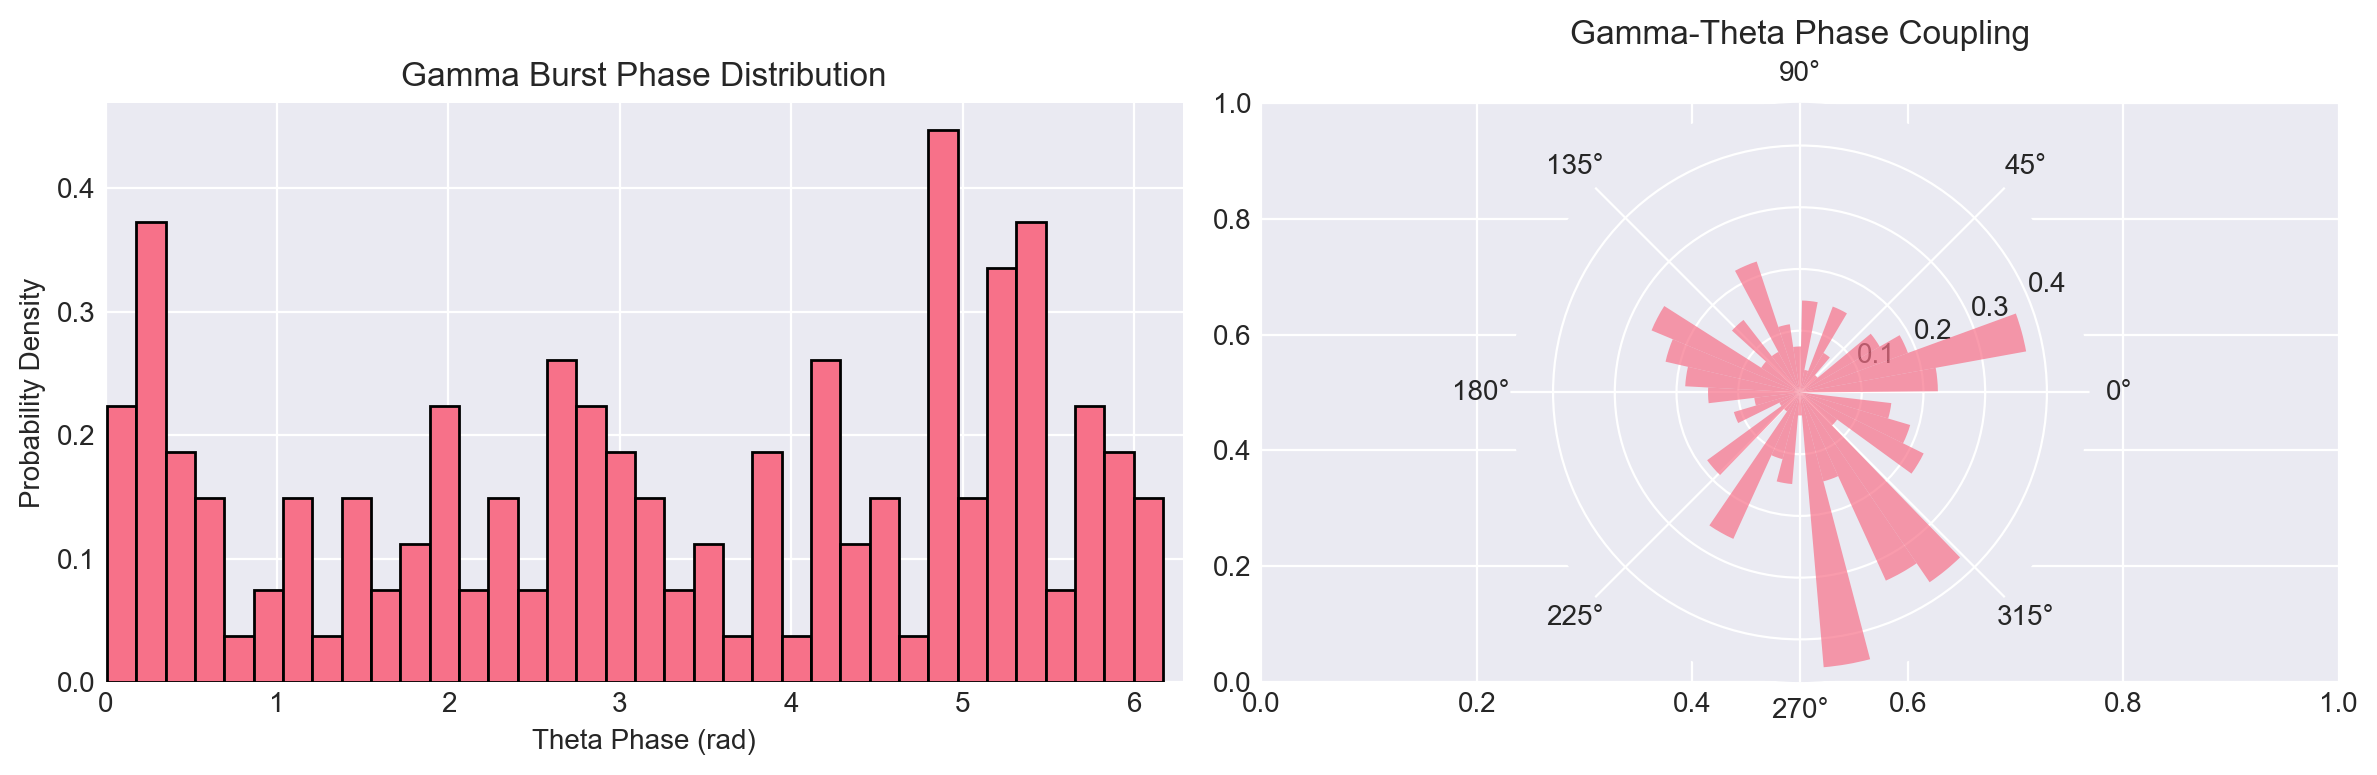


Gamma-theta coupling:
  Rayleigh Z = 2.939, p = 0.0527


In [16]:
# Detect gamma bursts
print("Detecting gamma bursts...")
gamma_bursts, gamma_envelope = detect_gamma_bursts(
    lfp_channel, fs, freq_band=GAMMA_BAND, z_threshold=2.0
)

print(f"Gamma bursts detected: {len(gamma_bursts)}")

# Align to theta phase
gamma_bursts = align_gamma_to_theta_phase(gamma_bursts, theta_phase, timestamps)

# Visualize gamma-theta coupling
gamma_phases = [b['theta_phase'] for b in gamma_bursts]

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Phase histogram
axes[0].hist(gamma_phases, bins=36, edgecolor='k', density=True)
axes[0].set_xlabel('Theta Phase (rad)')
axes[0].set_ylabel('Probability Density')
axes[0].set_title('Gamma Burst Phase Distribution')
axes[0].set_xlim([0, 2*np.pi])

# Polar plot
ax_polar = plt.subplot(122, projection='polar')
ax_polar.hist(gamma_phases, bins=36, density=True, alpha=0.7)
ax_polar.set_title('Gamma-Theta Phase Coupling')

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'gamma_theta_coupling.png', dpi=150)
plt.show()

# Test for significant coupling
rayleigh_result = rayleigh_test_phase_locking(gamma_phases)
print(f"\nGamma-theta coupling:")
print(f"  Rayleigh Z = {rayleigh_result['z']:.3f}, p = {rayleigh_result['p']:.4f}")

## 12. Spike-Phase Analysis for Individual Neurons

Analyzing 46 units...
Unit 0: 23 spikes, Preferred phase: 5.83 rad, Rayleigh p=0.1301
Unit 2: 15 spikes, Preferred phase: 3.91 rad, Rayleigh p=0.1083
Unit 3: 16 spikes, Preferred phase: 0.20 rad, Rayleigh p=0.0350
Unit 4: 12 spikes, Preferred phase: 2.03 rad, Rayleigh p=0.9280


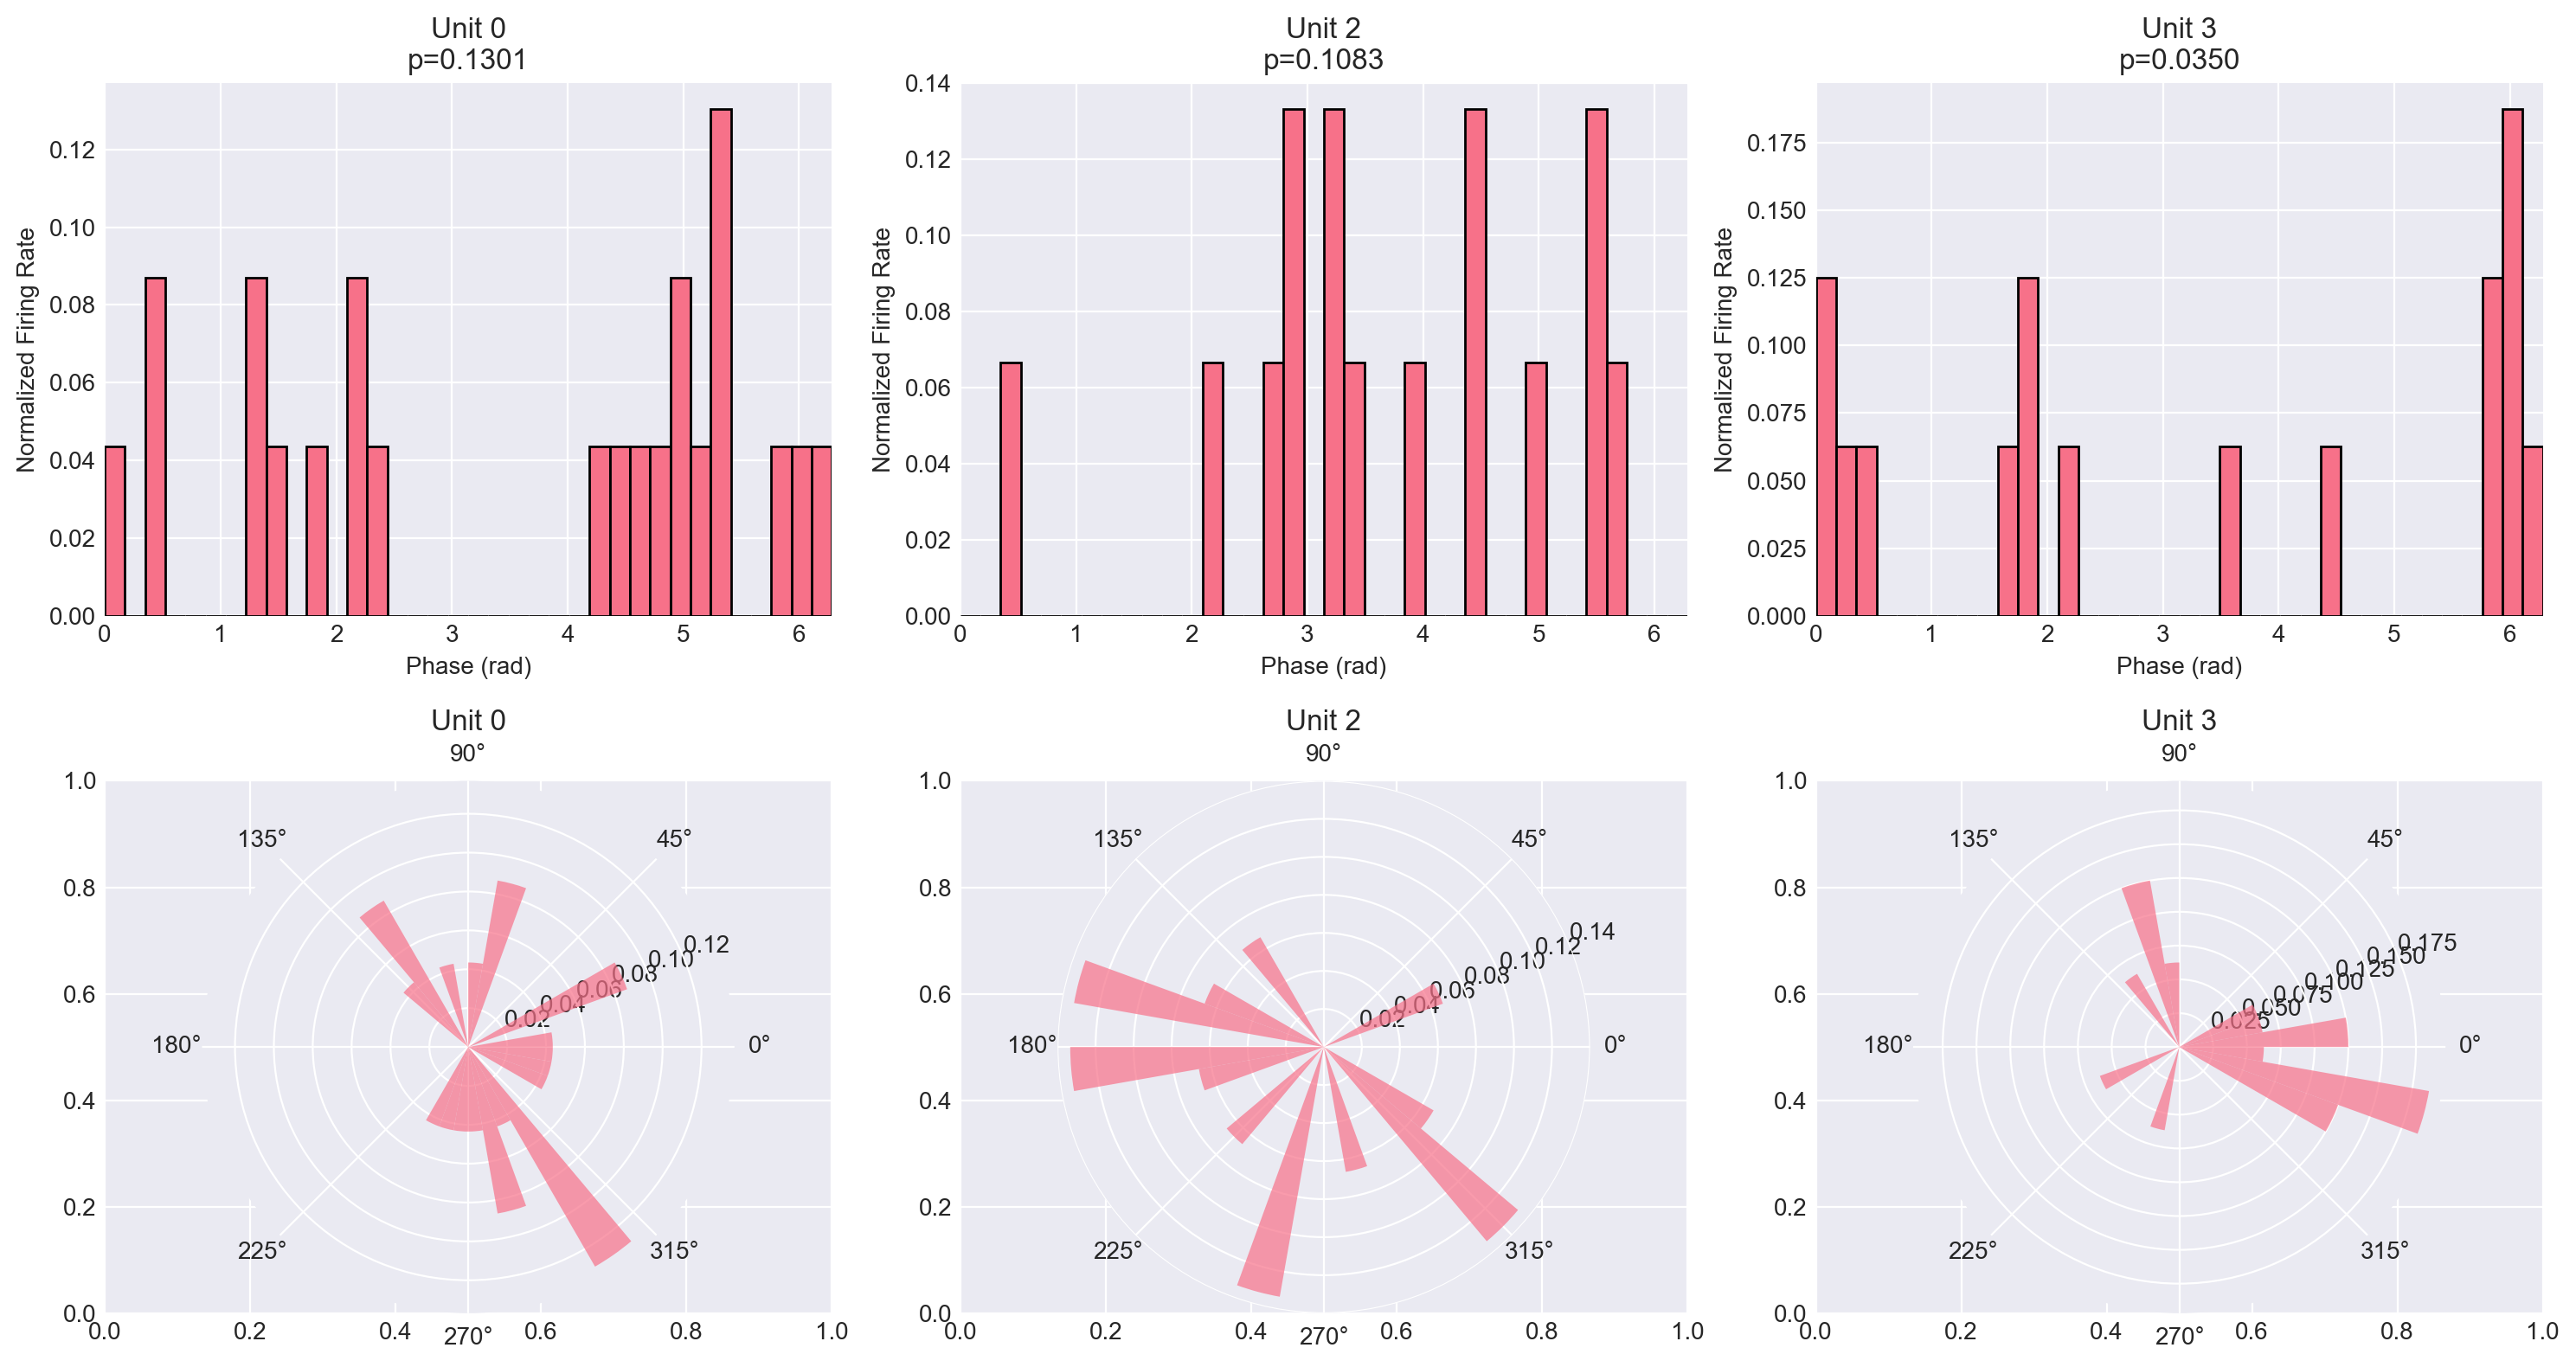

In [17]:
# Analyze spike-phase relationships
if 'spikes' in data and len(data['spikes']) > 0:
    print(f"Analyzing {len(data['spikes'])} units...")
    
    neuron_results = {}
    
    for unit_id, spike_times in list(data['spikes'].items())[:5]:  # First 5 units as example
        # Assign spikes to cycles
        spike_cycle_data = assign_spikes_to_cycles(spike_times, cycles_filtered)
        
        if len(spike_cycle_data) < 10:
            continue
        
        spike_phases = [s['phase'] for s in spike_cycle_data]
        
        # Compute phase tuning
        tuning = compute_phase_tuning(spike_phases)
        
        # Test significance
        rayleigh = rayleigh_test_phase_locking(spike_phases)
        
        neuron_results[unit_id] = {
            'spike_cycle_data': spike_cycle_data,
            'tuning': tuning,
            'rayleigh': rayleigh
        }
        
        print(f"Unit {unit_id}: {len(spike_phases)} spikes, "
              f"Preferred phase: {tuning['preferred_phase']:.2f} rad, "
              f"Rayleigh p={rayleigh['p']:.4f}")
    
    # Visualize phase tuning for example neurons
    n_neurons = len(neuron_results)
    if n_neurons > 0:
        fig, axes = plt.subplots(2, min(3, n_neurons), figsize=(15, 8))
        if n_neurons == 1:
            axes = axes.reshape(-1, 1)
        
        for idx, (unit_id, result) in enumerate(list(neuron_results.items())[:3]):
            tuning = result['tuning']
            
            # Linear plot
            axes[0, idx].bar(tuning['bin_centers'], tuning['firing_rate'], 
                            width=2*np.pi/len(tuning['bin_centers']), edgecolor='k')
            axes[0, idx].set_xlabel('Phase (rad)')
            axes[0, idx].set_ylabel('Normalized Firing Rate')
            axes[0, idx].set_title(f"Unit {unit_id}\np={result['rayleigh']['p']:.4f}")
            axes[0, idx].set_xlim([0, 2*np.pi])
            
            # Polar plot
            ax_polar = plt.subplot(2, min(3, n_neurons), idx + 4, projection='polar')
            ax_polar.bar(tuning['bin_centers'], tuning['firing_rate'], 
                        width=2*np.pi/len(tuning['bin_centers']), alpha=0.7)
            ax_polar.set_title(f"Unit {unit_id}")
        
        plt.tight_layout()
        plt.savefig(OUTPUT_DIR / 'spike_phase_tuning.png', dpi=150)
        plt.show()
else:
    print("No spike data available.")
    neuron_results = {}

## 13. Circular GLM Analysis

In [18]:
# Fit circular GLMs for phase coding
if len(neuron_results) > 0:
    print("Fitting circular GLMs...")
    
    glm_results = {}
    
    for unit_id, result in neuron_results.items():
        spike_cycle_data = result['spike_cycle_data']
        
        # Create design matrix
        phases = np.array([s['phase'] for s in spike_cycle_data])
        
        # Bin cycles and count spikes per bin
        n_bins = 20
        phase_bins = np.linspace(0, 2*np.pi, n_bins + 1)
        bin_centers = (phase_bins[:-1] + phase_bins[1:]) / 2
        spike_counts, _ = np.histogram(phases, bins=phase_bins)
        
        # Fit phase-only GLM
        try:
            glm_phase = fit_circular_glm_phase_only(bin_centers, spike_counts)
            glm_results[unit_id] = {'phase_only': glm_phase}
            
            print(f"Unit {unit_id}: Preferred phase = {glm_phase['preferred_phase']:.2f} rad, "
                  f"AIC = {glm_phase['aic']:.1f}")
        except Exception as e:
            print(f"GLM fitting failed for unit {unit_id}: {e}")
    
    print(f"\nSuccessfully fit GLMs for {len(glm_results)} units.")
else:
    print("No neuron results available for GLM fitting.")
    glm_results = {}

Fitting circular GLMs...
Unit 0: Preferred phase = 5.85 rad, AIC = 58.0
Unit 2: Preferred phase = 3.97 rad, AIC = 45.7
Unit 3: Preferred phase = 0.21 rad, AIC = 50.9
Unit 4: Preferred phase = 2.12 rad, AIC = 43.4

Successfully fit GLMs for 4 units.


## 14. Subcycle Position Decoding

Preparing subcycle decoding...
Feature matrix shape: (75, 32)
Features: 4 neurons × 8 phase bins = 32 features

Position decoding accuracy: 0.307 ± 0.080
Chance level: 0.333


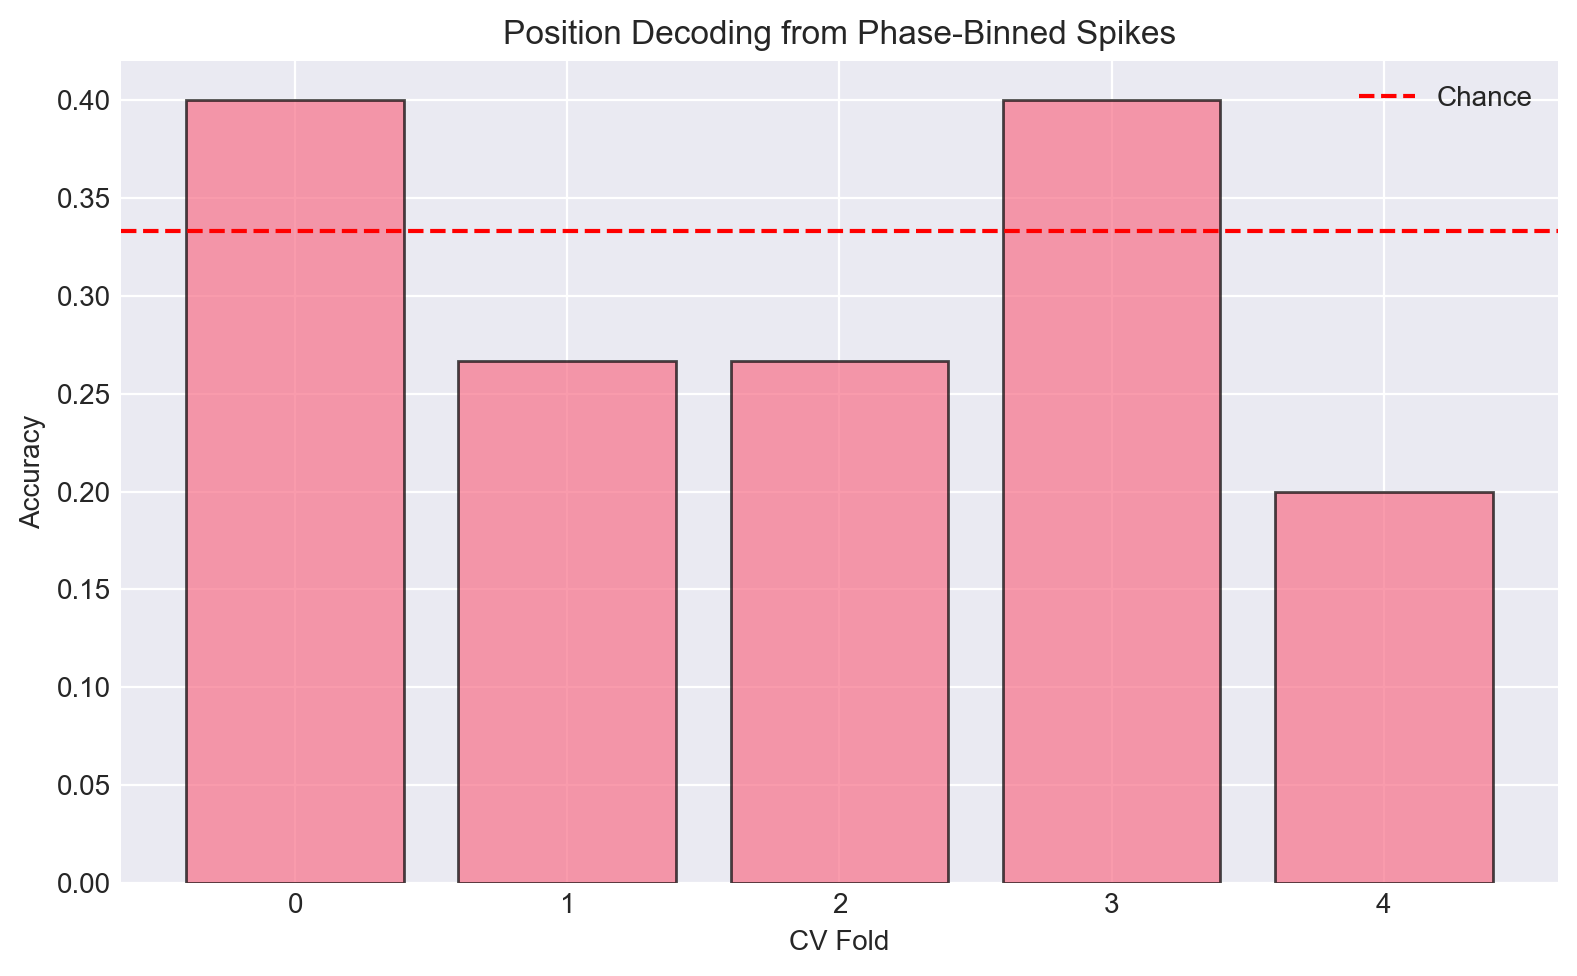

In [19]:
# Subcycle decoding (requires behavioral position data)
# This is a template - adapt based on actual trial structure

if len(neuron_results) >= 3 and 'trials' in data:
    print("Preparing subcycle decoding...")
    
    # Create phase-binned features
    spike_data_dict = {uid: res['spike_cycle_data'] for uid, res in neuron_results.items()}
    
    try:
        X, cycle_indices = create_phase_binned_features(
            cycles_filtered, spike_data_dict, n_phase_bins=N_PHASE_BINS
        )
        
        print(f"Feature matrix shape: {X.shape}")
        print(f"Features: {len(neuron_results)} neurons × {N_PHASE_BINS} phase bins = {X.shape[1]} features")
        
        # For demonstration: create synthetic position labels
        # In real analysis, extract from trials_df
        y_position = np.random.randint(0, 3, size=len(cycle_indices))  # 3 positions
        
        # Decode position
        decoding_result = decode_position_from_phase_bins(
            X, y_position, classifier='nb', n_folds=N_CV_FOLDS
        )
        
        print(f"\nPosition decoding accuracy: {decoding_result['mean_accuracy']:.3f} ± {decoding_result['std_accuracy']:.3f}")
        print(f"Chance level: {1/len(np.unique(y_position)):.3f}")
        
        # Visualize decoding accuracy
        fig, ax = plt.subplots(1, 1, figsize=(8, 5))
        ax.bar(range(len(decoding_result['cv_scores'])), decoding_result['cv_scores'], 
               edgecolor='k', alpha=0.7)
        ax.axhline(1/len(np.unique(y_position)), color='r', linestyle='--', label='Chance')
        ax.set_xlabel('CV Fold')
        ax.set_ylabel('Accuracy')
        ax.set_title('Position Decoding from Phase-Binned Spikes')
        ax.legend()
        plt.tight_layout()
        plt.savefig(OUTPUT_DIR / 'decoding_accuracy.png', dpi=150)
        plt.show()
        
    except Exception as e:
        print(f"Decoding failed: {e}")
else:
    print("Insufficient data for decoding analysis.")

## 15. Phase Remapping Analysis (Maintenance → Retrieval)

In [20]:
# Phase remapping test
# This requires trial structure with maintenance and retrieval epochs

if 'trials' in data and len(data['trials']) > 0:
    print("Analyzing phase remapping across task epochs...")
    
    trials_df = data['trials']
    
    # Extract cycles by epoch
    maintenance_cycles = extract_trial_epochs(cycles_filtered, trials_df, 'maintenance')
    retrieval_cycles = extract_trial_epochs(cycles_filtered, trials_df, 'retrieval')
    
    print(f"Maintenance cycles: {len(maintenance_cycles)}")
    print(f"Retrieval cycles: {len(retrieval_cycles)}")
    
    # For each neuron, compare phase preferences
    if len(neuron_results) > 0:
        for unit_id, result in list(neuron_results.items())[:3]:
            spike_times = data['spikes'][unit_id]
            
            # Assign spikes to epoch-specific cycles
            maint_spike_data = assign_spikes_to_cycles(spike_times, maintenance_cycles)
            retr_spike_data = assign_spikes_to_cycles(spike_times, retrieval_cycles)
            
            if len(maint_spike_data) > 5 and len(retr_spike_data) > 5:
                maint_phases = [s['phase'] for s in maint_spike_data]
                retr_phases = [s['phase'] for s in retr_spike_data]
                
                maint_mean = circmean(maint_phases)
                retr_mean = circmean(retr_phases)
                
                phase_shift = np.angle(np.exp(1j * (retr_mean - maint_mean)))
                
                print(f"Unit {unit_id}: Phase shift = {phase_shift:.3f} rad ({np.degrees(phase_shift):.1f}°)")
else:
    print("No trial data available for remapping analysis.")

Analyzing phase remapping across task epochs...
Maintenance cycles: 47
Retrieval cycles: 2


## 16. Cross-Subject Analysis

Cross-subject analysis template...
To run full analysis, process all subjects and collect phase preferences.

Group-level phase consistency:
  Rayleigh Z = 2.232, p = 0.1064
  Concentration κ = 0.778
  Group mean phase = 1.625 rad


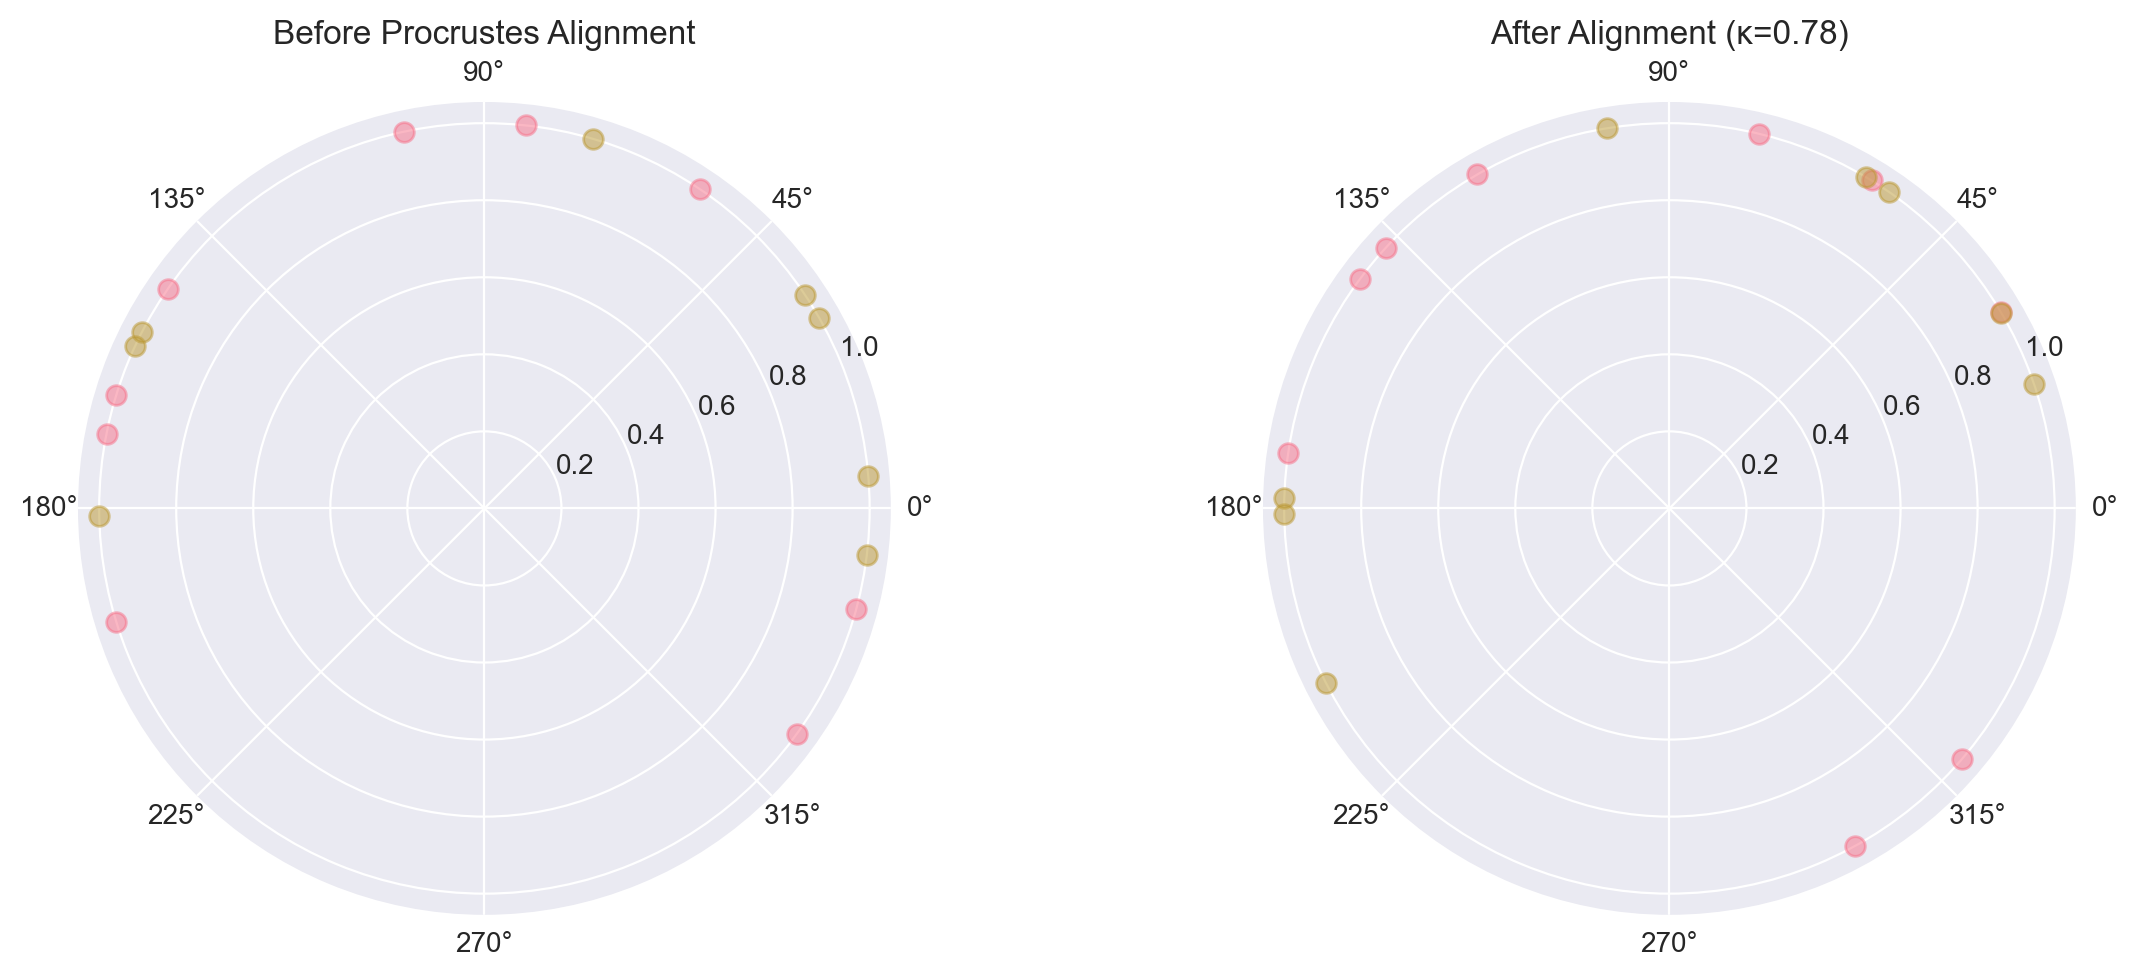

In [21]:
# Cross-subject phase consistency
# This requires processing multiple subjects

print("Cross-subject analysis template...")
print("To run full analysis, process all subjects and collect phase preferences.")

# Template for collecting results
all_subjects_phase_preferences = {}

# Example: process first 3 subjects
for subject_file in all_files[:3]:
    try:
        subject_data = load_nwb_file(subject_file)
        subject_id = subject_data['nwbfile'].subject.subject_id if subject_data['nwbfile'].subject else str(subject_file)
        
        # Extract preferred phases (placeholder - would need full pipeline)
        # For demonstration, use random phases
        n_electrodes = np.random.randint(5, 15)
        phase_prefs = np.random.uniform(0, 2*np.pi, n_electrodes)
        
        all_subjects_phase_preferences[subject_id] = phase_prefs
        
        subject_data['io'].close()
        
    except Exception as e:
        print(f"Error loading {subject_file}: {e}")

if len(all_subjects_phase_preferences) > 1:
    # Procrustes alignment
    aligned_phases, group_mean = circular_procrustes_alignment(all_subjects_phase_preferences)
    
    # Group statistics
    group_stats = compute_group_phase_consistency(aligned_phases)
    
    print(f"\nGroup-level phase consistency:")
    print(f"  Rayleigh Z = {group_stats['rayleigh_z']:.3f}, p = {group_stats['rayleigh_p']:.4f}")
    print(f"  Concentration κ = {group_stats['concentration']:.3f}")
    print(f"  Group mean phase = {group_stats['circular_mean']:.3f} rad")
    
    # Visualize
    fig = plt.figure(figsize=(12, 5))
    
    # Before alignment
    ax1 = plt.subplot(121, projection='polar')
    for subject_id, phases in all_subjects_phase_preferences.items():
        ax1.scatter(phases, np.ones(len(phases)), alpha=0.5, s=50)
    ax1.set_title('Before Procrustes Alignment')
    
    # After alignment
    ax2 = plt.subplot(122, projection='polar')
    all_aligned = []
    for subject_id, phases in aligned_phases.items():
        ax2.scatter(phases, np.ones(len(phases)), alpha=0.5, s=50)
        all_aligned.extend(phases)
    ax2.set_title(f'After Alignment (κ={group_stats["concentration"]:.2f})')
    
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / 'cross_subject_alignment.png', dpi=150)
    plt.show()

## 17. Statistical Controls: Phase Shuffling

Generating phase-shuffle surrogates...

Unit 0:
  Observed Rayleigh Z = 2.038
  Surrogate mean Z = 0.989 ± 0.971
  Empirical p-value = 0.1260


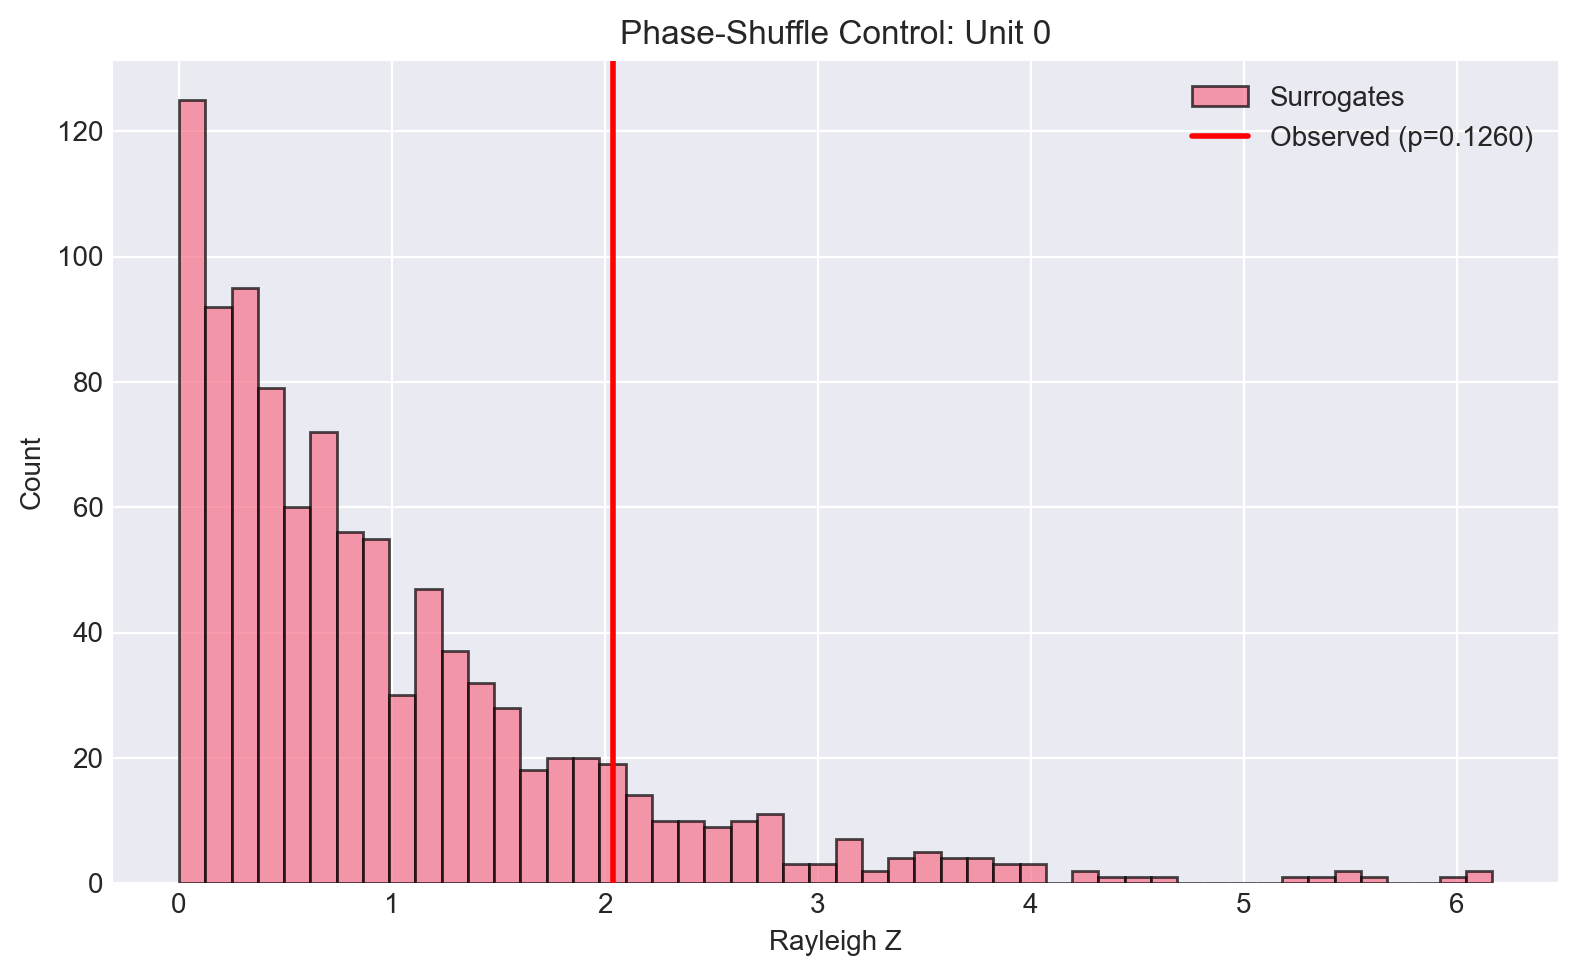

In [22]:
# Phase shuffle surrogates
if len(neuron_results) > 0:
    print("Generating phase-shuffle surrogates...")
    
    # Take first neuron as example
    example_unit = list(neuron_results.keys())[0]
    spike_data = neuron_results[example_unit]['spike_cycle_data']
    observed_rayleigh = neuron_results[example_unit]['rayleigh']['z']
    
    # Generate surrogates
    surrogates = generate_phase_shuffle_surrogates(spike_data, cycles_filtered, n_surrogates=N_SURROGATES)
    
    # Compute Rayleigh Z for each surrogate
    def rayleigh_z(phases):
        if len(phases) < 2:
            return 0
        z, _ = rayleigh_test(phases)
        return z
    
    surrogate_zs = compute_surrogate_statistics(surrogates, rayleigh_z)
    
    # Empirical p-value
    p_emp = compute_empirical_pvalue(observed_rayleigh, surrogate_zs)
    
    print(f"\nUnit {example_unit}:")
    print(f"  Observed Rayleigh Z = {observed_rayleigh:.3f}")
    print(f"  Surrogate mean Z = {np.mean(surrogate_zs):.3f} ± {np.std(surrogate_zs):.3f}")
    print(f"  Empirical p-value = {p_emp:.4f}")
    
    # Visualize
    fig, ax = plt.subplots(1, 1, figsize=(8, 5))
    ax.hist(surrogate_zs, bins=50, alpha=0.7, edgecolor='k', label='Surrogates')
    ax.axvline(observed_rayleigh, color='r', linewidth=2, label=f'Observed (p={p_emp:.4f})')
    ax.set_xlabel('Rayleigh Z')
    ax.set_ylabel('Count')
    ax.set_title(f'Phase-Shuffle Control: Unit {example_unit}')
    ax.legend()
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / 'phase_shuffle_control.png', dpi=150)
    plt.show()

## 18. 1/f Aperiodic Correction

Computing power spectrum and 1/f correction...
1/f slope: -1.911
1/f intercept: 2.358


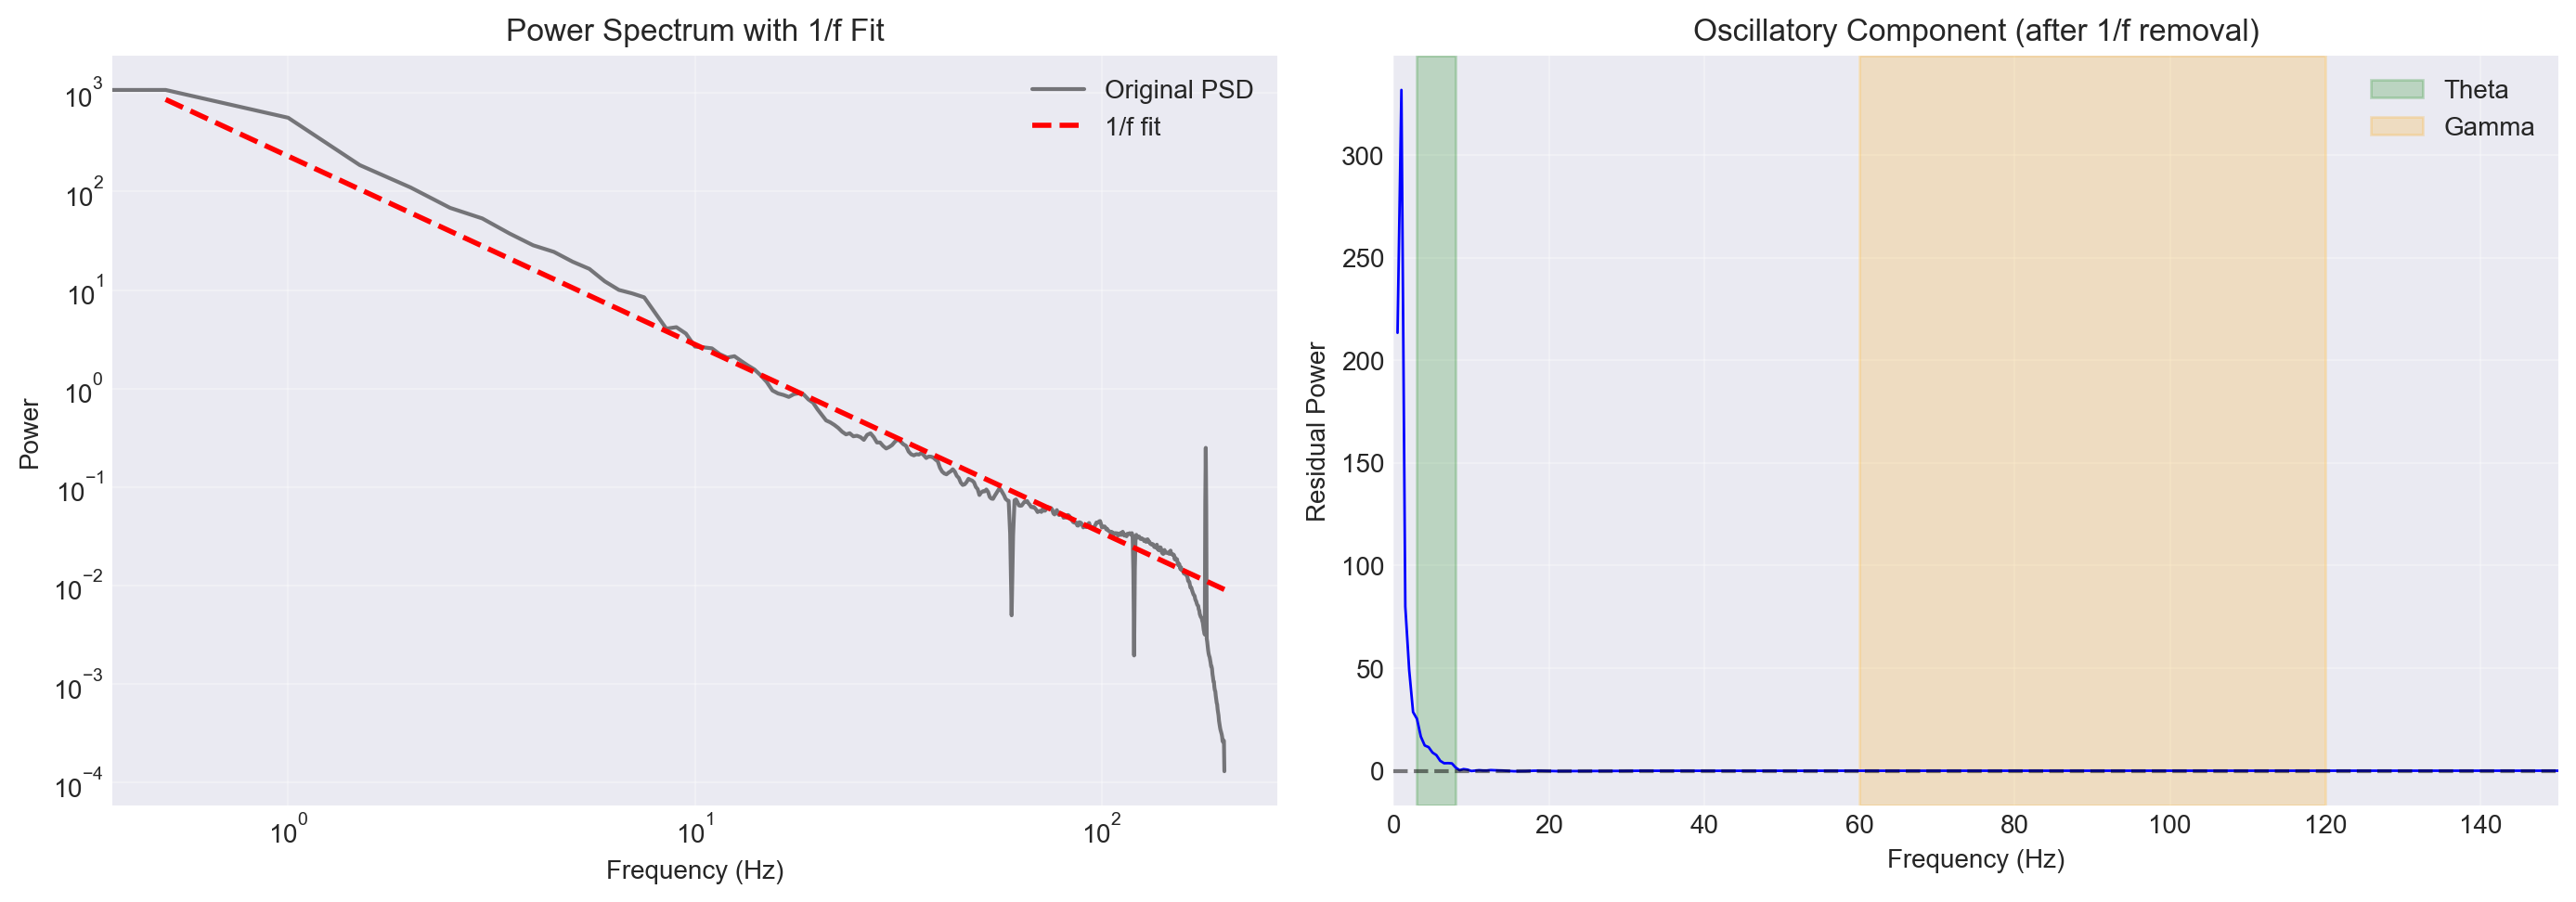

In [23]:
# Compute power spectrum and fit 1/f
print("Computing power spectrum and 1/f correction...")

# Compute PSD
from scipy.signal import welch
freqs, psd = welch(lfp_channel, fs=fs, nperseg=int(2*fs))

# Fit 1/f
aperiodic_result = fit_1f_background(freqs, psd, freq_range=(1, 150))

print(f"1/f slope: {aperiodic_result['slope']:.3f}")
print(f"1/f intercept: {aperiodic_result['intercept']:.3f}")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Log-log plot
axes[0].loglog(freqs, psd, 'k', alpha=0.5, label='Original PSD')
axes[0].loglog(freqs, aperiodic_result['aperiodic_fit'], 'r--', linewidth=2, label='1/f fit')
axes[0].set_xlabel('Frequency (Hz)')
axes[0].set_ylabel('Power')
axes[0].set_title('Power Spectrum with 1/f Fit')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Residual (oscillatory component)
axes[1].plot(freqs, aperiodic_result['residual'], 'b', linewidth=1)
axes[1].axhline(0, color='k', linestyle='--', alpha=0.5)
axes[1].axvspan(THETA_BAND[0], THETA_BAND[1], alpha=0.2, color='green', label='Theta')
axes[1].axvspan(GAMMA_BAND[0], GAMMA_BAND[1], alpha=0.2, color='orange', label='Gamma')
axes[1].set_xlabel('Frequency (Hz)')
axes[1].set_ylabel('Residual Power')
axes[1].set_title('Oscillatory Component (after 1/f removal)')
axes[1].set_xlim([0, 150])
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUT_DIR / '1f_correction.png', dpi=150)
plt.show()

## 19. Summary Statistics Export

In [24]:
# Compile summary statistics
summary = {
    'session': {
        'file': str(example_file),
        'subject_id': nwbfile.subject.subject_id if nwbfile.subject else 'Unknown',
        'n_units': len(data['spikes']) if 'spikes' in data else 0,
        'n_trials': len(data['trials']) if 'trials' in data else 0
    },
    'theta_cycles': {
        'n_raw': len(cycles_raw),
        'n_filtered': len(cycles_filtered),
        'mean_duration': np.mean([c['duration'] for c in cycles_filtered]),
        'mean_snr': np.mean([c['snr'] for c in cycles_filtered])
    },
    'gamma_bursts': {
        'n_bursts': len(gamma_bursts),
        'mean_duration': np.mean([b['duration'] for b in gamma_bursts]) if gamma_bursts else 0,
        'rayleigh_z': rayleigh_result['z'],
        'rayleigh_p': rayleigh_result['p']
    },
    'spike_phase_results': {}
}

for unit_id, result in neuron_results.items():
    summary['spike_phase_results'][str(unit_id)] = {
        'n_spikes': result['tuning']['n_spikes'],
        'preferred_phase': float(result['tuning']['preferred_phase']),
        'concentration': float(result['tuning']['concentration']),
        'rayleigh_z': float(result['rayleigh']['z']),
        'rayleigh_p': float(result['rayleigh']['p'])
    }

# Save to JSON
import json
with open(OUTPUT_DIR / 'analysis_summary.json', 'w') as f:
    json.dump(summary, f, indent=2)

print("\nAnalysis summary saved to:", OUTPUT_DIR / 'analysis_summary.json')
print("\nAll analysis complete!")
print(f"Output directory: {OUTPUT_DIR}")


Analysis summary saved to: /Users/jundazhu/SBCAT/analysis_output/analysis_summary.json

All analysis complete!
Output directory: /Users/jundazhu/SBCAT/analysis_output


## 20. Next Steps & Extensions

**To complete the full analysis pipeline**:

1. **Iterate over all subjects**: Wrap the main analysis in a loop over `all_files`

2. **Extract behavioral covariates**: From `trials_df`, extract:
   - Position/location during each cycle
   - Stimulus identity (which items in working memory)
   - Memory load (1, 2, or 3 items)
   - Task epoch (encoding, maintenance, retrieval)

3. **Fit full GLM models**: Use behavioral covariates to fit:
   - Phase × Position interaction
   - Phase × Identity interaction  
   - Phase × Load interaction

4. **Cross-temporal decoding**: Create temporal generalization matrices by training on early cycles and testing on late cycles

5. **Remapping with behavioral context**: Test if phase remapping is specific to queried items vs non-queried items

6. **Population analysis**: Aggregate results across all neurons and subjects for group-level statistics

7. **High-gamma envelope decoding**: Use gamma envelope amplitude (in addition to spike counts) as decoding features

8. **Stationarity checks**: Divide recording into time windows and verify phase preferences are stable

**Code adaptations needed**:
- Inspect actual NWB file structure to extract correct LFP channels (hippocampal vs frontal)
- Map trial structure to extract task epochs and behavioral variables
- Identify PAC neurons (neurons with phase-amplitude modulation) vs non-PAC neurons
- Implement frontal-hippocampal coherence analysis for control demand periods